# System Preparation

## Install requirements

In [1]:
import importlib
import subprocess
try:
    # Check if the module is already installed
    importlib.import_module('torch')
    print("torch is already installed.")
except ImportError:
    # If the module is not installed, try installing it
    subprocess.run(['pip3', 'install', 'torch', 'torchvision', 'torchaudio', '--index-url', 'https://download.pytorch.org/whl/cu118'])
    print("torch was installed correctly.")

import torch
print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.randn(1).cuda())
else:
    #get torch here: https://pytorch.org/get-started/locally/
    subprocess.run(['pip3', 'uninstall', 'torch'])
    subprocess.run(['pip3', 'install', 'torch', 'torchvision', 'torchaudio', '--index-url', 'https://download.pytorch.org/whl/cu118'])

torch is already installed.
Torch version: 2.1.1+cu118
Is CUDA enabled? True
tensor([-0.6192], device='cuda:0')


In [ ]:
#install requirements
!pip install nltk  
!pip install gdown
!pip install pandas
!pip install bertopic
!pip install wordcloud
!pip install matplotlib
!pip install bertopic[visualization]  #This has to be installed separately

In [1]:
import pychatgpt as op

What is the meaning of "fitting" a model in machine learning
When we talk about "fitting" a model in machine learning, we are essentially referring to the process of training the model on a dataset. By "pretraining" a model, we mean that the model has been initially trained on a large dataset (which may or may not be similar to the dataset you are working with) before being fine-tuned on the specific dataset you are interested in.

Pretraining a model helps in capturing general patterns and features from the initial dataset, which can then be fine-tuned on a smaller, more specific dataset. This process is especially useful when you have limited data for your specific task, as the pretrained model can provide a good starting point that can be adapted to your particular problem.

When you "fit" a pretrained model, you are essentially adjusting the model's parameters to fit the patterns and relationships present in your specific dataset. This fine-tuning process helps the model learn the specific nuances of your data and improve its performance on your particular task. 

In summary, fitting a pretrained model in machine learning involves taking a model that has already been trained on a different dataset and adjusting it to better suit the patterns present in your own data.

## Import packages

In [2]:
# Import packages
import os
import io
import sys
import ast
import re
import random
import zipfile
import requests
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
if not 'google.colab' in sys.modules:
    !pip install pyperclip
    import pyperclip as pc

# Plotly: Set notebook mode to work offline
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode()

# Set data directory
data_path = 'data/'


# Define functions

def simple_bool(message):
    choose = input(message+" (y/n): ").lower()
    your_bool = choose in ["y", "yes","yea","sure"]
    return your_bool
        
def get_gitfile(url, flag='', dir = os.getcwd()):
    url = url.replace('blob','raw')
    response = requests.get(url)
    file_name = flag + url.rsplit('/',1)[1]
    file_path = os.path.join(dir, file_name)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully. Saved as {file_name}")
    else:
        print("Unable to download the file.")

#get_gitfile("https://raw.githubusercontent.com/johndef64/pyutilities_datascience/main/general_utilities.py")

# Get Docs from Scopus 

https://www.scopus.com/search/form.uri?zone=TopNavBar&origin=&display=basic#basic

Search String:
TITLE-ABS-KEY(("integrative bioinformatic*" OR "data integrat*" OR "database integrat*" OR "network integrat*" OR "integrative analys*") AND ("multi-omic*" OR "pan-omic*" OR "integrative omic*" OR "trans-omic*" OR "vertical omic*" OR "integrated omic*"  OR "*omic* integration" OR "trans-omic* data integration" OR "trans-omic* network*" )  )  AND PUBYEAR > 2003 AND PUBYEAR < 2025 AND ( LIMIT-TO ( SUBJAREA , "BIOC" ) OR LIMIT-TO ( SUBJAREA , "COMP" ) OR LIMIT-TO ( SUBJAREA , "MEDI" ) OR LIMIT-TO ( SUBJAREA , "PHAR" ) )

In [62]:
#### Load Corpus
def load_corpus_from_csv(doc_name = 'scopus.csv', abs_col= 'Abstract'):
    global docs
    
    df = pd.read_csv(doc_name, index_col=0)
    df['paper_texts'] = df["Title"] + " $ " + df["Abstract"] 
    docs = df['paper_texts'].drop_duplicates().to_list()
    #docs = df.Abstract.drop_duplicates().to_list()
    
    print('\nEntry count:',len(df),
          '\nAbstract count:', df[abs_col].nunique(),
          '\nEntry without abstract:',len(df)-df.Abstract.nunique())

    return docs

docs = load_corpus_from_csv(data_path+"scopus.csv")
pd.Series(docs)


Entry count: 1324 
Abstract count: 1295 
Entry without abstract: 29


0       scCorrector: a robust method for integrating m...
1       Benchmarking multi-omics integration algorithm...
2       Multi-omics data integration shines a light on...
3       Multi-Chemical Omics Analysis of the Symbiodin...
4       Integrative analysis with machine learning ide...
                              ...                        
1318    UniVIO: A multiple omics database with hormono...
1319    Multi-omic network signatures of disease $ To ...
1320    Integrated visualization of a multi-omics stud...
1321    Erratum to Identification of ovarian cancer dr...
1322    Computational ecosystems for data-driven medic...
Length: 1323, dtype: object

## Corpus preprocessing

### - nltk preprocessing* 
1.  import nltk for stemming and stopword removal
2.  remove stopwords and then stem the abstracts

*[not needed with Fine-Tuning Representations]

In [ ]:
#download stopwords and the punkt tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [63]:
%%time 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# lower text keeping acronyms uppercase
def conservative_lower(text):
    # Split the text into words
    words = text.split()
    
    # Lowercase the words that don't have consecutive uppercase letters
    processed_words = [word.lower() if not re.search('[A-Z]{2,}', word) else word for word in words]
    
    # Join the processed words back into text
    processed_text = ' '.join(processed_words)
    return processed_text


def text_preprocessing(text, 
                       stem = True, 
                       trim = True, 
                       conservative = False):
    word_tokens = word_tokenize(text)
    # 1. Lowercase
    if conservative:
        word_tokens = [conservative_lower(word) for word in word_tokens] 
    else:
        word_tokens = [word.lower() for word in word_tokens]

    # 2. Trimming: stop word removal
    if trim:
        word_tokens = [word for word in word_tokens if word not in stop_words] 
        
    # 3. Stemming
    if stem:
        word_tokens = [stemmer.stem(word) for word in word_tokens]
    return " ".join(word_tokens)


def nltk_preprocessing(docs_to_process, stem = False, trim= True, conservative=True):
    docs_preprocessed = [text_preprocessing(doc, stem, trim, conservative) for doc in docs_to_process]
    return docs_preprocessed
    
    
docs_to_process = docs #.random.sample(docs, 100)

# Docs Preprocessing
docs_preprocessed = nltk_preprocessing(docs_to_process, stem = False, conservative=True)
docs_less_processed = nltk_preprocessing(docs_to_process, stem = False, trim= False, conservative=True)

print(docs_to_process[1],'\n========')
print(docs_preprocessed[1])
len(docs_preprocessed)

Benchmarking multi-omics integration algorithms across single-cell RNA and ATAC data $ Recent advancements in single-cell sequencing technologies have generated extensive omics data in various modalities and revolutionized cell research, especially in the single-cell RNA and ATAC data. The joint analysis across scRNA-seq data and scATAC-seq data has paved the way to comprehending the cellular heterogeneity and complex cellular regulatory networks. Multi-omics integration is gaining attention as an important step in joint analysis, and the number of computational tools in this field is growing rapidly. In this paper, we benchmarked 12 multi-omics integration methods on three integration tasks via qualitative visualization and quantitative metrics, considering six main aspects that matter in multi-omics data analysis. Overall, we found that different methods have their own advantages on different aspects, while some methods outperformed other methods in most aspects. We therefore provide

1323

# Topic modeling (BERTopic)
BERT: Bidirectional Encoder Representations from Transformers

1.   Default setting - Vanilla (Extras)
2.   Custom - choose embedding model and set clustering parameters

## BERTopic - Read The Docs
https://bertopic.readthedocs.io/en/latest/#

## Default setting

In [64]:
from bertopic import BERTopic

def get_topic_info(topic_model):
    df = topic_model.get_topic_info()
    return df

def get_document_info(topic_model, docs_processed):
    doc_info = topic_model.get_document_info(docs_processed)
    return doc_info

In [65]:
%%time
# Fine-tune your topic representations
topic_model = BERTopic()
topic_model_base = topic_model.fit(docs_preprocessed)

get_topic_info(topic_model_base)

CPU times: total: 32.7 s
Wall time: 25 s


Topic  Count                                               Name  \
0      -1    446            -1_data_analysis_multiomics_integration   
1       0     87                       0_singlecell_cell_cells_data   
2       1     81                1_data_multiomics_learning_medicine   
3       2     62                2_data_omics_integration_biological   
4       3     58                          3_cancer_breast_data_gene   
5       4     52                  4_clustering_data_cancer_subtypes   
6       5     44            5_microbiome_microbial_data_integration   
7       6     43                      6_cancer_deep_data_multiomics   
8       7     42                  7_hcc_immune_expression_carcinoma   
9       8     40                    8_methylation_genes_genetic_dna   
10      9     37                  9_data_cancer_analysis_multiomics   
11     10     34                 10_lung_luad_adenocarcinoma_cancer   
12     11     34                      11_ad_alzheimer_brain_disease   
13     12     31           12_gut_microbiota_microbiome_metabolites   
14     13     29                       13_plant_rice_csrnf217_maize   
15     14     22           14_graph_cancer_convolutional_multiomics   
16     15     21                        15_skin_sle_pathogenesis_ad   
17     16     21                   16_cardiovascular_heart_hfpef_hf   
18     17     18                   17_gbm_glioma_signature_patients   
19     18     17                      18_crc_colorectal_cancer_cnvs   
20     19     17  19_metabolomics_metabolites_analysis_metaboana...   
21     20     17              20_covid19_vaccine_sarscov2_influenza   
22     21     16                21_metabolic_models_flux_metabolism   
23     22     15            22_networks_interactions_autophagy_node   
24     23     15                        23_asthma_copd_disease_lung   
25     24     12              24_stress_pm25_endothelial_metabolism   
26     25     12               25_regulatory_networks_gene_intomics   

                                       Representation  \
0   [data, analysis, multiomics, integration, omic...   
1   [singlecell, cell, cells, data, multimodal, in...   
2   [data, multiomics, learning, medicine, integra...   
3   [data, omics, integration, biological, visuali...   
4   [cancer, breast, data, gene, pathways, genomic...   
5   [clustering, data, cancer, subtypes, similarit...   
6   [microbiome, microbial, data, integration, mul...   
7   [cancer, deep, data, multiomics, learning, sub...   
8   [hcc, immune, expression, carcinoma, genes, ca...   
9   [methylation, genes, genetic, dna, gwas, loci,...   
10  [data, cancer, analysis, multiomics, integrati...   
11  [lung, luad, adenocarcinoma, cancer, survival,...   
12  [ad, alzheimer, brain, disease, data, cognitiv...   
13  [gut, microbiota, microbiome, metabolites, fec...   
14  [plant, rice, csrnf217, maize, plants, ougan, ...   
15  [graph, cancer, convolutional, multiomics, cla...   
16  [skin, sle, pathogenesis, ad, immune, eoe, inf...   
17  [cardiovascular, heart, hfpef, hf, cvd, mi, fa...   
18  [gbm, glioma, signature, patients, analysis, p...   
19  [crc, colorectal, cancer, cnvs, eocrc, immune,...   
20  [metabolomics, metabolites, analysis, metaboan...   
21  [covid19, vaccine, sarscov2, influenza, virus,...   
22  [metabolic, models, flux, metabolism, genomesc...   
23  [networks, interactions, autophagy, node, netw...   
24  [asthma, copd, disease, lung, pulmonary, hiv, ...   
25  [stress, pm25, endothelial, metabolism, effect...   
26  [regulatory, networks, gene, intomics, biologi...   

                                  Representative_Docs  
0   [multilevel omic data integration cancer cell ...  
1   [scMIC : deep multi-level information fusion f...  
2   [practicing precision medicine intelligently i...  
3   [practical evaluation different omics data int...  
4   [ATHENA : identifying interactions different l...  
5   [cancer subtype discovery based integrative mo...  
6   [computational approac

In [66]:
%%time
# Fine-tune your topic representations
topic_model = BERTopic()

# Apply to un-processed docs
topic_model_base = topic_model.fit(docs)

get_topic_info(topic_model_base)

CPU times: total: 28.8 s
Wall time: 18.5 s


Topic  Count                                 Name  \
0      -1    375                     -1_the_and_of_to   
1       0    121                  0_cancer_the_of_and   
2       1     98            1_singlecell_cell_the_and   
3       2     91             2_microbiome_and_gut_the   
4       3     77                    3_data_and_of_the   
5       4     50               4_cancer_deep_the_data   
6       5     48                   5_and_of_the_genes   
7       6     45         6_clustering_cancer_data_the   
8       7     44                   7_and_in_of_immune   
9       8     37                   8_lung_luad_and_in   
10      9     36     9_networks_network_regulatory_of   
11     10     35           10_metabolomics_of_the_and   
12     11     35                11_data_the_of_cancer   
13     12     32                   12_plant_the_in_of   
14     13     27           13_ad_alzheimers_and_brain   
15     14     20        14_visualization_and_data_the   
16     15     19         15_cardiovascular_of_and_the   
17     16     18      16_covid19_vaccine_and_sarscov2   
18     17     16         17_crc_colorectal_cancer_and   
19     18     16                 18_of_the_systems_to   
20     19     15  19_metabolic_models_genomescale_the   
21     20     15                20_obesity_and_in_the   
22     21     15                  21_skin_and_sle_the   
23     22     13       22_graph_cancer_the_multiomics   
24     23     13          23_gbm_glioma_signature_and   
25     24     12       24_sparse_analysis_multiple_of   

                                       Representation  \
0   [the, and, of, to, in, data, for, multiomics, ...   
1   [cancer, the, of, and, to, data, in, for, with...   
2   [singlecell, cell, the, and, data, of, cells, ...   
3   [microbiome, and, gut, the, in, of, microbiota...   
4   [data, and, of, the, to, integration, omics, i...   
5   [cancer, deep, the, data, learning, multiomics...   
6   [and, of, the, genes, methylation, in, genetic...   
7   [clustering, cancer, data, the, to, subtypes, ...   
8   [and, in, of, immune, the, expression, hcc, wi...   
9   [lung, luad, and, in, adenocarcinoma, the, of,...   
10  [networks, network, regulatory, of, the, and, ...   
11  [metabolomics, of, the, and, in, to, analysis,...   
12  [data, the, of, cancer, multiomics, for, to, a...   
13  [plant, the, in, of, and, to, rice, csrnf217, ...   
14  [ad, alzheimers, and, brain, disease, of, the,...   
15  [visualization, and, data, the, for, analysis,...   
16  [cardiovascular, of, and, the, heart, in, hf, ...   
17  [covid19, vaccine, and, sarscov2, influenza, o...   
18  [crc, colorectal, cancer, and, of, the, in, im...   
19  [of, the, systems, to, and, toxicogenomics, da...   
20  [metabolic, models, genomescale, the, flux, of...   
21  [obesity, and, in, the, of, metabolic, with, m...   
22  [skin, and, sle, the, of, in, ad, pathogenesis...   
23  [graph, cancer, the, multiomics, convolutional...   
24  [gbm, glioma, signature, and, the, of, in, pro...   
25  [sparse, analysis, multiple, of, variables, mc...   

                                  Representative_Docs  
0   [A systemic analysis of transcriptomic and epi...  
1   [Identification of ovarian cancer driver genes...  
2   [Predictive modeling of single-cell DNA methyl...  
3   [Multi-omics analysis revealing the interplay ...  
4   [A guide to multi-omics data collection and in...  
5   [A deep learning fusion clustering framework f...  
6   [Multi-omics study for interpretation of genom...  
7   [A similarity regression fusion model for inte...  
8   [Integrative analysis revealed a correlation o...  
9   [Signatures of Multi-Omics Reveal Distinct Tum...  
10  [Network reconstruction for trans acting genet...  
11  [Approaches to integrating metabolomics and mu...  
12  [Artificial Intelligence to Decode Cancer Mech...  
13  [Multi-omics Data Integration in the Context o...  
14  [Alzheimer's disease prediction based on conti...  
15  [Valorizing omics visual

## 1. Embedding Documents

BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

In [67]:
m='''
convertthis into a amrkdown table
'''
op.delamain(m)

```markdown
| Model Name           | Description                                       | Dimensions | Size  | Note                                                          |
|----------------------|--------------------------------------------------|------------|-------|---------------------------------------------------------------|
| all-mpnet-base-v2    | All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. | 768 | 420 MB | Designed as a general-purpose model, the all-mpnet-base-v2 model provides the best quality. |
| all-MiniLM-L12-v2    | All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. | 384 | 120 MB | While all-MiniLM-L6-v2 is 5 times faster and still offers good quality. |
```  
 <prompt tokens: 1194>


### BERT Pretrained Models
https://www.sbert.net/docs/pretrained_models.html


| Model Name           | Description                                       | Dimensions | Size  | Note                                                          |
|----------------------|--------------------------------------------------|------------|-------|---------------------------------------------------------------|
| all-mpnet-base-v2    | All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. | 768 | 420 MB | Designed as a general-purpose model, the all-mpnet-base-v2 model provides the best quality. |
| all-MiniLM-L12-v2    | All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. | 384 | 120 MB | While all-MiniLM-L6-v2 is 5 times faster and still offers good quality. |


### Other Models

Scientific Publications
SPECTER is a model trained on scientific citations and can be used to estimate the similarity of two publications. We can use it to find similar papers.

"allenai-specter" - Semantic Search Python Example / Semantic Search Colab Example

### Sentence Transformers

In [30]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # "all-mpnet-base-v2"

In [121]:
%%time
topic_model = BERTopic(embedding_model=embedding_model)
topic_model =  topic_model.fit(docs_preprocessed)

get_topic_info(topic_model)

CPU times: total: 24.5 s
Wall time: 17.3 s


Topic  Count                                      Name  \
0      -1    426              -1_data_omics_multi_analysis   
1       0    119       0_data_omics_integration_biological   
2       1     91     1_microbiome_gut_microbiota_microbial   
3       2     85                 2_cancer_data_breast_gene   
4       3     84                   3_cell_single_cells_seq   
5       4     50         4_clustering_cancer_subtypes_data   
6       5     46          5_methylation_genetic_genes_gwas   
7       6     37                 6_asthma_copd_immune_skin   
8       7     35              7_ad_brain_alzheimer_disease   
9       8     30       8_luad_lung_adenocarcinoma_survival   
10      9     26  9_metabolomics_metabolites_acid_analysis   
11     10     26            10_cardiovascular_heart_hf_cvd   
12     11     26               11_cancer_deep_multi_breast   
13     12     22                12_hcc_liver_immune_cancer   
14     13     21             13_cancer_learning_data_omics   
15     14     19      14_medicine_precision_clinical_omics   
16     15     19         15_methylation_genes_dna_kiaa1429   
17     16     19                   16_covid_19_vaccine_cov   
18     17     18          17_glioma_gbm_signature_patients   
19     18     16        18_aging_obesity_insulin_metabolic   
20     19     16       19_metabolic_models_flux_metabolism   
21     20     15      20_graph_omics_cancer_classification   
22     21     14                  21_drug_data_moa_network   
23     22     13               22_crc_colorectal_eocrc_wnt   
24     23     12                        23_ibd_pain_cd_dch   
25     24     10             24_immune_vsir_tumor_response   

                                       Representation  \
0   [data, omics, multi, analysis, cancer, integra...   
1   [data, omics, integration, biological, multi, ...   
2   [microbiome, gut, microbiota, microbial, host,...   
3   [cancer, data, breast, gene, pathway, pathways...   
4   [cell, single, cells, seq, data, omics, datase...   
5   [clustering, cancer, subtypes, data, method, m...   
6   [methylation, genetic, genes, gwas, dna, assoc...   
7   [asthma, copd, immune, skin, disease, sle, pat...   
8   [ad, brain, alzheimer, disease, data, omics, c...   
9   [luad, lung, adenocarcinoma, survival, nsclc, ...   
10  [metabolomics, metabolites, acid, analysis, me...   
11  [cardiovascular, heart, hf, cvd, plasma, myoca...   
12  [cancer, deep, multi, breast, data, omics, lea...   
13  [hcc, liver, immune, cancer, lihc, expression,...   
14  [cancer, learning, data, omics, drug, multi, t...   
15  [medicine, precision, clinical, omics, data, t...   
16  [methylation, genes, dna, kiaa1429, expression...   
17  [covid, 19, vaccine, cov, sars, influenza, vir...   
18  [glioma, gbm, signature, patients, risk, analy...   
19  [aging, obesity, insulin, metabolic, t2d, adip...   
20  [metabolic, models, flux, metabolism, strain, ...   
21  [graph, omics, cancer, classification, multi, ...   
22  [drug, data, moa, network, methods, discovery,...   
23  [crc, colorectal, eocrc, wnt, fgrs, immune, hy...   
24  [ibd, pain, cd, dch, intestinal, sii, gsh, cli...   
25  [immune, vsir, tumor, response, cells, tlrs, c...   

                                  Representative_Docs  
0   [order improve understanding cancer develop mu...  
1   [abstract : sequencing technologies evolving r...  
2   [recent studies demonstrated gut microbiota pl...  
3   [background : integrative analysis multi-omics...  
4   [single-cell studies enabling understanding mo...  
5   [due high heterogeneity complexity cancers , p...  
6   [identification genes regulatory elements unde...  
7   [atopic dermatitis ( ad ) condition driven cel...  
8   [background : recent dna/rna sequencing multi-...  
9   [lung cancer prevalent cancer worldwide . 80 %...  
10  [background : meat quality complex trait affec...  
11  [background : patients suffering acute myocard...  
12  [high prevalence breast cancer , urgent find i...  
13  [

### 🤗 Hugging Face Transformers

In [68]:
%%time
from transformers.pipelines import pipeline
embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")

topic_model = BERTopic(embedding_model=embedding_model)
topic_model_inspired = topic_model.fit(docs_preprocessed)

get_topic_info(topic_model_inspired)

CPU times: total: 18min 7s
Wall time: 4min 39s


Topic  Count                                  Name  \
0      0   1296           0_data_omics_multi_analysis   
1      1     27  1_abstract_available_editorial_omics   

                                      Representation  \
0  [data, omics, multi, analysis, cancer, integra...   
1  [abstract, available, editorial, omics, multi,...   

                                 Representative_Docs  
0  [topological integration RPPA proteomic data m...  
1  [editorial : multi-omic data integration oncol...

### Custom embeddings

In [ ]:
%%time
# Use a custom embeddings. Preprocessing nltk is necessary
from sentence_transformers import SentenceTransformer
# Prepare embeddings
""" SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. """

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs_preprocessed, show_progress_bar=True)
embeddings_docs = embedding_model.encode(docs, show_progress_bar=True)
# np.savetxt(data_path+'abs_embeddings.txt', embeddings)

print('type',type(embeddings))
embeddings[:5]

In [70]:
%%time
#embeddings = np.loadtxt(save_path + 'abs_embeddings.txt')
topic_model = BERTopic(embedding_model = embedding_model)
topic_model_base = topic_model.fit(docs_preprocessed, embeddings=embeddings)

get_topic_info(topic_model_base)

CPU times: total: 12.3 s
Wall time: 7.3 s


Topic  Count                                      Name  \
0      -1    417              -1_data_omics_multi_analysis   
1       0     86                   0_cell_single_cells_seq   
2       1     85     1_data_omics_integration_metabolomics   
3       2     53         2_clustering_data_cancer_subtypes   
4       3     49             3_learning_data_omics_machine   
5       4     47            4_hcc_cancer_immune_expression   
6       5     47                 5_breast_cancer_gene_data   
7       6     46           6_methylation_genes_genetic_dna   
8       7     43              7_deep_cancer_learning_multi   
9       8     40          8_microbiome_microbial_host_data   
10      9     36              9_ad_alzheimer_brain_disease   
11     10     36                10_cancer_data_omics_multi   
12     11     31              11_plant_rice_csrnf217_maize   
13     12     31        12_lung_luad_adenocarcinoma_cancer   
14     13     30  13_gut_microbiome_microbiota_metabolites   
15     14     22        14_graph_omics_multi_convolutional   
16     15     21           15_skin_sle_immune_inflammatory   
17     16     20          16_cardiovascular_heart_hfpef_hf   
18     17     18           17_crc_colorectal_cancer_immune   
19     18     18                   18_covid_19_vaccine_cov   
20     19     18               19_gbm_glioma_signature_lgg   
21     20     18          20_stress_metabolism_hypoxia_pm2   
22     21     17             21_asthma_copd_lung_pulmonary   
23     22     16            22_digital_drugs_como_medicine   
24     23     16       23_metabolic_models_flux_metabolism   
25     24     15       24_regulatory_networks_gene_network   
26     25     14  25_networks_disease_network_interactions   
27     26     13          26_t2d_obesity_insulin_metabolic   
28     27     10           27_mirna_lncrnas_lncbook_mirnas   
29     28     10           28_hgsoc_ovarian_endometrial_ec   

                                       Representation  \
0   [data, omics, multi, analysis, integration, ca...   
1   [cell, single, cells, seq, data, multimodal, o...   
2   [data, omics, integration, metabolomics, biolo...   
3   [clustering, data, cancer, subtypes, multi, me...   
4   [learning, data, omics, machine, multi, ai, in...   
5   [hcc, cancer, immune, expression, genes, carci...   
6   [breast, cancer, gene, data, pathways, pathway...   
7   [methylation, genes, genetic, dna, gene, gwas,...   
8   [deep, cancer, learning, multi, data, omics, s...   
9   [microbiome, microbial, host, data, multi, gut...   
10  [ad, alzheimer, brain, disease, cognitive, dat...   
11  [cancer, data, omics, multi, analysis, integra...   
12  [plant, rice, csrnf217, maize, plants, ougan, ...   
13  [lung, luad, adenocarcinoma, cancer, survival,...   
14  [gut, microbiome, microbiota, metabolites, fec...   
15  [graph, omics, multi, convolutional, cancer, c...   
16  [skin, sle, immune, inflammatory, monocytes, e...   
17  [cardiovascular, heart, hfpef, hf, mi, cvd, fa...   
18  [crc, colorectal, cancer, immune, wnt, cnvs, e...   
19  [covid, 19, vaccine, cov, sars, influenza, vir...   
20  [gbm, glioma, signature, lgg, patients, analys...   
21  [stress, metabolism, hypoxia, pm2, dehp, cashm...   
22  [asthma, copd, lung, pulmonary, disease, fibro...   
23  [digital, drugs, como, medicine, drug, precisi...   
24  [metabolic, models, flux, metabolism, scale, m...   
25  [regulatory, networks, gene, network, biologic...   
26  [networks, disease, network, interactions, nod...   
27  [t2d, obesity, insulin, metabolic, adipocytes,...   
28  [mirna, lncrnas, lncbook, mirnas, si, human, s...   
29  [hgsoc, ovarian, endometrial, ec, iprofun, uf,...   

                                  Representative_Docs  
0   [unsupervised multi-omics data integration met...  
1   [integration scATAC-Seq scRNA-Seq data $ singl...  
2   [holomics - user-friendly r shiny application ...  
3   [PNF : novel method based connectivity similar...  
4   [applications multi-omics ana

In [282]:
%%time
#embeddings = np.loadtxt(save_path + 'abs_embeddings.txt')
topic_model = BERTopic(embedding_model = embedding_model)
topic_model_base = topic_model.fit(docs, embeddings=embeddings_docs)

get_topic_info(topic_model_base)

CPU times: total: 14 s
Wall time: 8.25 s


Topic  Count                                        Name  \
0      -1    365                            -1_the_of_and_to   
1       0     99             0_microbiome_and_gut_microbiota   
2       1     77                      1_cell_single_the_data   
3       2     65                      2_lung_cancer_and_luad   
4       3     57                           3_the_data_of_and   
5       4     49           4_clustering_cancer_data_subtypes   
6       5     48                          5_and_asthma_of_in   
7       6     41                 6_integration_data_of_omics   
8       7     40                          7_plant_the_in_and   
9       8     38                      8_cancer_deep_the_data   
10      9     31                    9_methylation_and_of_the   
11     10     31                    10_cancer_breast_the_and   
12     11     30               11_networks_regulatory_of_the   
13     12     25              12_heart_cardiovascular_and_of   
14     13     24                 13_ad_alzheimer_disease_and   
15     14     23                14_crc_colorectal_cancer_and   
16     15     23                     15_covid_19_vaccine_and   
17     16     22          16_visualization_network_and_omics   
18     17     21       17_hcc_liver_hepatocellular_carcinoma   
19     18     21                 18_metabolomics_of_data_the   
20     19     19                   19_the_stress_of_exposure   
21     20     19           20_cancer_pathways_modules_driver   
22     21     17                21_metabolic_models_the_flux   
23     22     16                           22_gwas_of_the_to   
24     23     16                 23_graph_omics_cancer_multi   
25     24     16                       24_cancer_data_and_of   
26     25     15        25_data_resources_kbcommons_database   
27     26     15                     26_analysis_data_the_of   
28     27     13            27_gbm_glioma_signature_patients   
29     28     13  28_chromatin_stem_regulatory_accessibility   
30     29     12               29_obesity_plasma_aging_lipid   
31     30     11            30_drug_learning_deep_anticancer   
32     31     11                       31_muscle_meat_and_in   

                                       Representation  \
0   [the, of, and, to, in, data, omics, multi, for...   
1   [microbiome, and, gut, microbiota, the, in, of...   
2   [cell, single, the, data, cells, multimodal, o...   
3   [lung, cancer, and, luad, immune, in, of, the,...   
4   [the, data, of, and, in, for, learning, to, me...   
5   [clustering, cancer, data, subtypes, the, to, ...   
6   [and, asthma, of, in, the, copd, to, immune, w...   
7   [integration, data, of, omics, the, and, to, b...   
8   [plant, the, in, and, of, to, rice, plants, ma...   
9   [cancer, deep, the, data, subtypes, learning, ...   
10  [methylation, and, of, the, in, genetic, dna, ...   
11  [cancer, breast, the, and, of, hgsoc, in, with...   
12  [networks, regulatory, of, the, data, to, biol...   
13  [heart, cardiovascular, and, of, the, hfpef, i...   
14  [ad, alzheimer, disease, and, of, brain, the, ...   
15  [crc, colorectal, cancer, and, in, of, the, gc...   
16  [covid, 19, vaccine, and, cov, sars, influenza...   
17  [visualization, network, and, omics, of, for, ...   
18  [hcc, liver, hepatocellular, carcinoma, were, ...   
19  [metabolomics, of, data, the, and, analysis, t...   
20  [the, stress, of, exposure, to, and, in, toxic...   
21  [cancer, pathways, modules, driver, the, data,...   
22  [metabolic, models, the, flux, of, to, scale, ...   
23  [gwas, of, the, to, and, association, studies,...   
24  [graph, omics, cancer, multi, the, convolution...   
25  [cancer, data, and, of, tcga, the, to, omics, ...   
26  [data, resources, kbcommons, database, for, we...   
27  [analysis, data, the, of, sparse, variables, m...   
28  [gbm, glioma, signature, patients, and, analys...   
29  [chromatin, stem, regulatory, accessibility, d...   
30  [obesity, plasma, aging, lipid, and, hdl, in, ...   
31 

In [71]:
%%time
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings_large = embedding_model.encode(docs_preprocessed, show_progress_bar=True)
# np.savetxt(data_path+'abs_embeddings.txt', embeddings)

print('type',type(embeddings_large))
embeddings_large[:5]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

type <class 'numpy.ndarray'>
CPU times: total: 1min 36s
Wall time: 1min 15s


array([[-0.05196006,  0.05066146,  0.00395503, ..., -0.0405201 ,
        -0.04791329, -0.02088017],
       [-0.04833724,  0.03387865, -0.01373494, ..., -0.03802268,
        -0.07078543,  0.01547578],
       [-0.02779642,  0.04634123, -0.00594067, ..., -0.04412532,
        -0.04807221,  0.02854106],
       [-0.01208559,  0.04576609, -0.02769323, ..., -0.03233367,
        -0.07307038, -0.01495648],
       [-0.02839287,  0.01029371, -0.01266597, ..., -0.03282505,
        -0.06130227, -0.01528199]], dtype=float32)

In [81]:
%%time

#embeddings = np.loadtxt(save_path + 'abs_embeddings.txt')
topic_model = BERTopic(embedding_model = embedding_model)
topic_model_large = topic_model.fit(docs_preprocessed, embeddings=embeddings_large)

get_topic_info(topic_model_large)

CPU times: total: 13.2 s
Wall time: 7.82 s


Topic  Count                               Name  \
0      -1    347                   -1_the_of_and_to   
1       0    102           0_microbiome_and_gut_the   
2       1     88              1_cell_single_the_and   
3       2     66            2_the_omics_cancer_data   
4       3     65               3_and_immune_luad_in   
5       4     47                 4_and_of_in_asthma   
6       5     44  5_clustering_cancer_data_subtypes   
7       6     40                  6_data_and_the_of   
8       7     38                 7_plant_the_and_of   
9       8     33           8_networks_to_of_network   
10      9     33          9_metabolomics_of_and_the   
11     10     30               10_data_omics_and_of   
12     11     29              11_cancer_the_gene_to   
13     12     26                12_and_heart_the_of   
14     13     25              13_cancer_data_of_and   
15     14     24         14_methylation_gwas_of_and   
16     15     23              15_hcc_liver_and_were   
17     16     23          16_crc_colorectal_and_the   
18     17     23          17_learning_drug_deep_for   
19     18     22            18_covid_19_vaccine_and   
20     19     21             19_ad_and_alzheimer_of   
21     20     20         20_metabolic_models_the_of   
22     21     20          21_the_of_stress_exposure   
23     22     19       22_visualization_maps_and_of   
24     23     17      23_data_analysis_of_variables   
25     24     16          24_breast_cancer_tnbc_the   
26     25     16             25_and_of_the_disorder   
27     26     14         26_gbm_glioma_patients_and   
28     27     13               27_hgsoc_and_with_of   
29     28     11             28_muscle_meat_and_the   

                                       Representation  \
0   [the, of, and, to, in, data, omics, for, we, m...   
1   [microbiome, and, gut, the, in, microbiota, of...   
2   [cell, single, the, and, data, cells, of, to, ...   
3   [the, omics, cancer, data, multi, to, learning...   
4   [and, immune, luad, in, cancer, of, the, lung,...   
5   [and, of, in, asthma, the, to, immune, with, c...   
6   [clustering, cancer, data, subtypes, the, to, ...   
7   [data, and, the, of, in, to, medicine, clinica...   
8   [plant, the, and, of, in, to, rice, plants, wa...   
9   [networks, to, of, network, the, regulatory, d...   
10  [metabolomics, of, and, the, to, data, analysi...   
11  [data, omics, and, of, the, to, biological, fo...   
12  [cancer, the, gene, to, data, pathway, pathway...   
13  [and, heart, the, of, cardiovascular, hfpef, i...   
14  [cancer, data, of, and, the, to, tumor, for, o...   
15  [methylation, gwas, of, and, the, association,...   
16  [hcc, liver, and, were, hepatocellular, in, of...   
17  [crc, colorectal, and, the, cancer, of, in, gc...   
18  [learning, drug, deep, for, prediction, of, ca...   
19  [covid, 19, vaccine, and, cov, sars, of, to, i...   
20  [ad, and, alzheimer, of, disease, brain, the, ...   
21  [metabolic, models, the, of, metabolism, and, ...   
22  [the, of, stress, exposure, and, to, in, pm2, ...   
23  [visualization, maps, and, of, the, network, o...   
24  [data, analysis, of, variables, the, sparse, m...   
25  [breast, cancer, tnbc, the, and, of, in, gene,...   
26  [and, of, the, disorder, in, bd, oud, scz, gen...   
27  [gbm, glioma, patients, and, the, of, signatur...   
28  [hgsoc, and, with, of, the, prostate, cancer, ...   
29  [muscle, meat, and, the, in, quality, of, rea,...   

                                  Representative_Docs  
0   [recent advances in high-throughput technologi...  
1   [the functional complexity of human gut microb...  
2   [single-cell studies are enabling our understa...  
3   [background: cancer subtype classification att...  
4   [background: the present study aimed to explor...  
5   [asthma is a multifactorial inflammatory disor...  
6   [recent advances in multi-omics databases have...  
7   [with the development and improvement of high-...  
8   [abstract: sequencing 

## 2. Dimensionality Reduction

As a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters, we simply define it and pass it to BERTopic.

Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)
In general, UMAP is based on a hypothesis called the manifold hypothesis, which holds that high-dimensionality data actually lie on varieties
of lower dimensionality. This means that although we have high dimensionality data, there are some representations of them in smaller dimensions.
UMAP Docs : https://umap-learn.readthedocs.io/en/latest/basic_usage.html
            https://umap-learn.readthedocs.io/en/latest/parameters.html
            

0         1         2         3         4         5         6    \
0 -0.041277 -0.042223  0.010366 -0.033725  0.020205  0.013166 -0.151229   
1  0.014000 -0.029798 -0.007557 -0.085364  0.006491 -0.030479 -0.108382   
2 -0.034986 -0.005350  0.057021 -0.083646 -0.024323 -0.044213 -0.038184   
3 -0.065993 -0.011781 -0.009965  0.053168  0.098045 -0.060296 -0.078873   
4  0.002381  0.009118 -0.055322 -0.059411 -0.016415  0.005501 -0.068968   

        7         8         9    ...       374       375       376       377  \
0 -0.030112 -0.034292 -0.041536  ...  0.078340  0.112273  0.031424 -0.015160   
1  0.002591  0.014477  0.012259  ... -0.015992  0.040169 -0.019963  0.008423   
2 -0.000411 -0.020677 -0.054296  ... -0.033153  0.092307 -0.059251  0.035712   
3  0.004176  0.015776 -0.042104  ... -0.047367  0.100815  0.004025  0.126211   
4 -0.038784 -0.032047 -0.104591  ...  0.034556  0.032105 -0.074399  0.045429   

        378       379       380       381       382       383  
0  0.038085  0.001749  0.032387 -0.040204 -0.096011  0.003031  
1  0.099896  0.033941  0.084552 -0.085909 -0.071160 -0.056765  
2  0.044604  0.013707  0.125778 -0.019908 -0.061827 -0.085570  
3  0.001828  0.039104  0.050638 -0.121223  0.040859 -0.072257  
4  0.054468  0.015504  0.074679 -0.102620  0.019994 -0.026835  

[5 rows x 384 columns]

0         1         2         3         4
0  4.345452 -1.310652  0.250875  5.507477  3.408423
1  4.391734 -1.387055  0.313361  5.752174  3.739836
2  5.872122 -2.214007  0.300950  8.559946  6.376313
3  4.694259 -2.958393 -0.587633  8.379650  6.885572
4  6.328916 -2.107217  2.147999  7.244761  4.840074

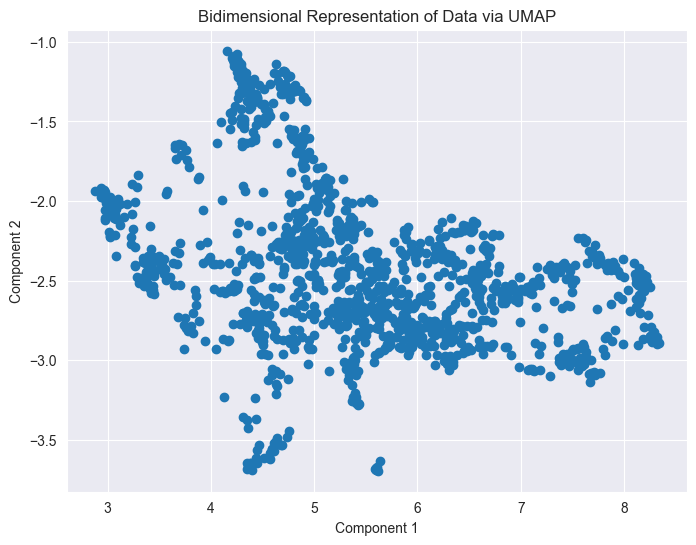

In [166]:
from umap import UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create dummy data: 100 samples with 10 features each
data = np.random.rand(100, 10)
data = embeddings

# Initialize UMAP model with specified parameters
umap_model = UMAP(n_neighbors  = 15,
                  n_components = 5,
                  min_dist     = 0.0,
                  metric='cosine',
                  random_state = 123456)

# Fit the model to the data and transform it
"""
we need to train our reducer, letting it learn about the manifold. For this UMAP has a method fit which we pass the data we want the model to learn from. Since, at the end of the day, we are going to want to reduced representation of the data we will use, instead, the fit_transform method which first calls fit and then returns the transformed data as a numpy array.
"""
reduced_embeddings = umap_model.fit_transform(data)

# embedding now contains the n-dimensional representation of the input data
display(pd.DataFrame(data)[:5])
display(pd.DataFrame(reduced_embeddings)[:5])


# Plot the bidimensional data
def plot_umap(reduced_embeddings):
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.title('Bidimensional Representation of Data via UMAP')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

plot_umap(reduced_embeddings)

Parameters: 

"n_neighbors" controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data.

"min_dist" controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation.

"n_components" allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into.

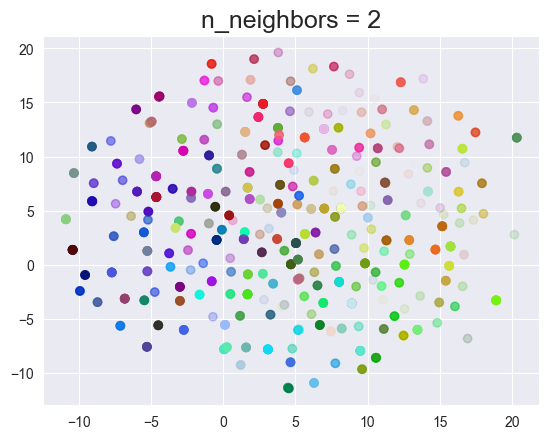

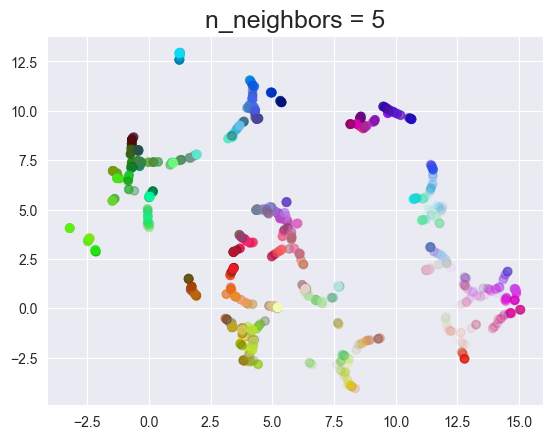

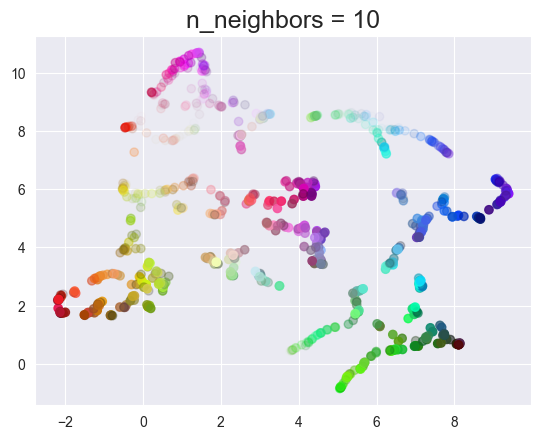

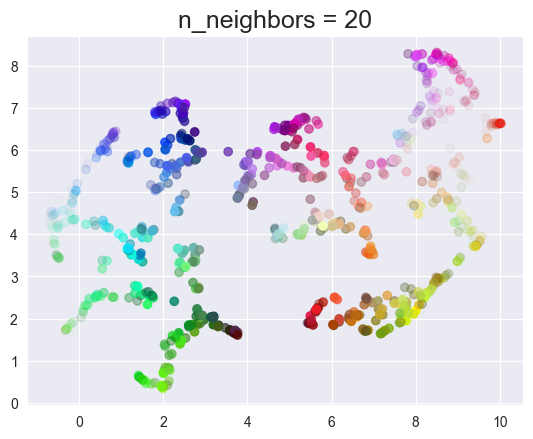

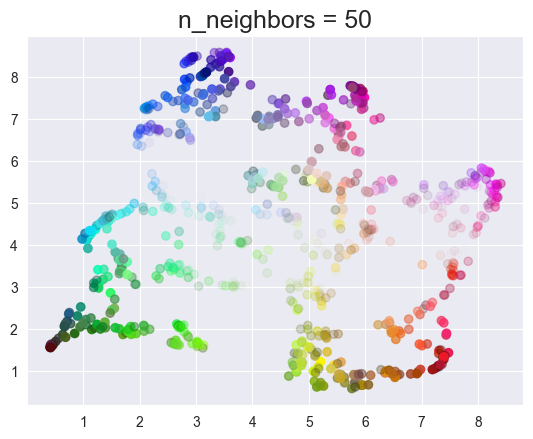

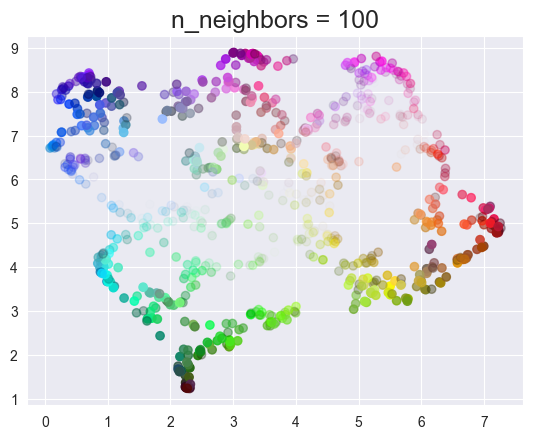

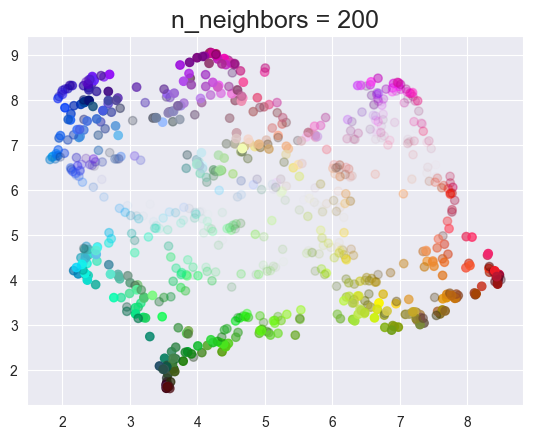

In [145]:
def apply_plot_umap(n_neighbors=15, min_dist=0.0, n_components=2, metric='cosine', title=''):
    fit = UMAP(n_neighbors  = n_neighbors,
               n_components = n_components,
               min_dist     = min_dist,
               metric=metric,
               random_state = 123456)
    
    #data = embeddings[:,0:4]
    np.random.seed(42)
    data = np.random.rand(800, 4)
    
    u = fit.fit_transform(data)
    
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)

    plt.title(title, fontsize=18)
    plt.show()
    return u

for n in (2, 5, 10, 20, 50, 100, 200):
    u = apply_plot_umap(n_neighbors=n, n_components=2, title='n_neighbors = {}'.format(n))

### Apply to BERTopic model

In [73]:
# Step 2 - Reduce dimensionality

from umap import UMAP
# uniform manifold approximation and projection (UMAP) to reduce the dimension of embeddings
umap_model = UMAP(n_neighbors  = 15, # 15 default
                  n_components = 5, # 5 default
                  min_dist     = 0.0,
                  metric='cosine',
                  random_state = 123456) # default:None

topic_model = BERTopic(umap_model=umap_model,
                       embedding_model = embedding_model
                       )
topic_model_umap = topic_model.fit(docs_preprocessed, embeddings=embeddings)

get_topic_info(topic_model_umap)

Topic  Count                                      Name  \
0      -1    437              -1_data_omics_multi_analysis   
1       0    150         0_data_omics_integration_analysis   
2       1     86                  1_cell_single_cells_data   
3       2     52               2_data_omics_learning_multi   
4       3     50            3_hcc_cancer_immune_expression   
5       4     47            4_clustering_cancer_data_multi   
6       5     46          5_methylation_genes_genetic_gwas   
7       6     46          6_microbiome_microbial_host_data   
8       7     39              7_cancer_deep_omics_learning   
9       8     36                 8_data_cancer_omics_multi   
10      9     33              9_ad_alzheimer_brain_disease   
11     10     33        10_lung_luad_adenocarcinoma_cancer   
12     11     32              11_plant_rice_csrnf217_maize   
13     12     31  12_gut_microbiota_microbiome_metabolites   
14     13     30             13_breast_cancer_gene_pathway   
15     14     19               14_graph_omics_cancer_multi   
16     15     19          15_cardiovascular_heart_hfpef_hf   
17     16     17          16_gbm_glioma_signature_analysis   
18     17     17               17_skin_eoe_ad_pathogenesis   
19     18     17              18_crc_colorectal_cancer_wnt   
20     19     16             19_asthma_copd_lung_pulmonary   
21     20     16       20_metabolic_models_flux_metabolism   
22     21     15          21_obesity_t2d_insulin_metabolic   
23     22     15                      22_covid_19_cov_sars   
24     23     13      23_regulatory_networks_gene_intomics   
25     24     11          24_hgsoc_ovarian_endometrial_age   

                                       Representation  \
0   [data, omics, multi, analysis, cancer, integra...   
1   [data, omics, integration, analysis, multi, me...   
2   [cell, single, cells, data, seq, multimodal, o...   
3   [data, omics, learning, multi, ai, machine, in...   
4   [hcc, cancer, immune, expression, genes, carci...   
5   [clustering, cancer, data, multi, subtypes, si...   
6   [methylation, genes, genetic, gwas, dna, gene,...   
7   [microbiome, microbial, host, data, multi, mic...   
8   [cancer, deep, omics, learning, data, multi, c...   
9   [data, cancer, omics, multi, analysis, integra...   
10  [ad, alzheimer, brain, disease, data, omics, m...   
11  [lung, luad, adenocarcinoma, cancer, nsclc, su...   
12  [plant, rice, csrnf217, maize, plants, express...   
13  [gut, microbiota, microbiome, metabolites, fec...   
14  [breast, cancer, gene, pathway, pathways, expr...   
15  [graph, omics, cancer, multi, classification, ...   
16  [cardiovascular, heart, hfpef, hf, mi, cvd, fa...   
17  [gbm, glioma, signature, analysis, patients, g...   
18  [skin, eoe, ad, pathogenesis, sle, immune, ra,...   
19  [crc, colorectal, cancer, wnt, cnvs, immune, e...   
20  [asthma, copd, lung, pulmonary, disease, ipf, ...   
21  [metabolic, models, flux, metabolism, model, s...   
22  [obesity, t2d, insulin, metabolic, aging, adip...   
23  [covid, 19, cov, sars, influenza, virus, vacci...   
24  [regulatory, networks, gene, intomics, biologi...   
25  [hgsoc, ovarian, endometrial, age, cancer, ec,...   

                                  Representative_Docs  
0   [integrative analysis multi-omics data discove...  
1   [integrated enrichment analysis pathway-center...  
2   [computational strategies single-cell multi-om...  
3   [integrated multi-omics analyses oncology : re...  
4   [whole genome RNA sequencing analyses 254 taiw...  
5   [multi-omics data fusion using adaptive GTO gu...  
6   [gene-methylation interactions : discovering r...  
7   [computational approaches integrative analysis...  
8   [classifying breast cancer subtypes using deep...  
9   [IOAT : interactive tool statistical analysis ...  
10  [harnessing endophenotypes network medicine al...  
11  [predictive signatures lung adenocarcinoma pro...  
12  [CARMO : comprehensive annotation platform fun...  
13  [

Although UMAP works quite well in BERTopic and is typically advised, you might want to be using PCA instead. It can be faster to train and perform inference. To use PCA, we can simply import it from sklearn and pass it to the umap_model parameter:

In [74]:
topic_model_umap.visualize_documents(docs_preprocessed)

0         1         2         3         4         5         6    \
0 -0.041277 -0.042223  0.010366 -0.033725  0.020205  0.013166 -0.151229   
1  0.014000 -0.029798 -0.007557 -0.085364  0.006491 -0.030479 -0.108382   
2 -0.034986 -0.005350  0.057021 -0.083646 -0.024323 -0.044213 -0.038184   
3 -0.065993 -0.011781 -0.009965  0.053168  0.098045 -0.060296 -0.078873   
4  0.002381  0.009118 -0.055322 -0.059411 -0.016415  0.005501 -0.068968   

        7         8         9    ...       374       375       376       377  \
0 -0.030112 -0.034292 -0.041536  ...  0.078340  0.112273  0.031424 -0.015160   
1  0.002591  0.014477  0.012259  ... -0.015992  0.040169 -0.019963  0.008423   
2 -0.000411 -0.020677 -0.054296  ... -0.033153  0.092307 -0.059251  0.035712   
3  0.004176  0.015776 -0.042104  ... -0.047367  0.100815  0.004025  0.126211   
4 -0.038784 -0.032047 -0.104591  ...  0.034556  0.032105 -0.074399  0.045429   

        378       379       380       381       382       383  
0  0.038085  0.001749  0.032387 -0.040204 -0.096011  0.003031  
1  0.099896  0.033941  0.084552 -0.085909 -0.071160 -0.056765  
2  0.044604  0.013707  0.125778 -0.019908 -0.061827 -0.085570  
3  0.001828  0.039104  0.050638 -0.121223  0.040859 -0.072257  
4  0.054468  0.015504  0.074679 -0.102620  0.019994 -0.026835  

[5 rows x 384 columns]

0         1         2         3         4
0  0.015635 -0.066581 -0.295341  0.259291 -0.196311
1 -0.035114 -0.126309 -0.375314 -0.078855 -0.181245
2  0.062874 -0.026582 -0.222816 -0.054336  0.001704
3  0.199537 -0.109286  0.026636 -0.009073 -0.182002
4 -0.154296  0.330365  0.041074  0.119113  0.081241

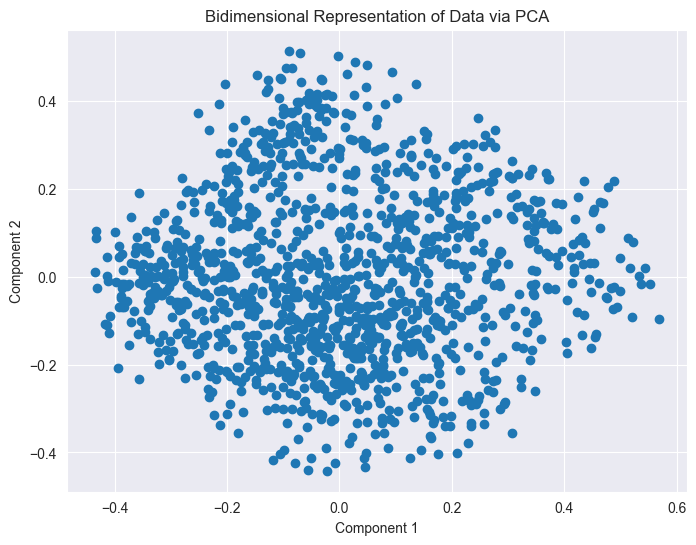

In [165]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create dummy data: 100 samples with 10 features each
data = np.random.rand(100, 10)
data = embeddings

# Initialize PCA model with specified parameters
dim_model = PCA(n_components=5)

# Fit the model to the data and transform it
reduced_embeddings = dim_model.fit_transform(data)

# embedding now contains the 5-dimensional representation of the input data
display(pd.DataFrame(data)[:5])
display(pd.DataFrame(reduced_embeddings)[:5])


# Plot the bidimensional data
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('Bidimensional Representation of Data via PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
###

In [147]:
from sklearn.decomposition import PCA

dim_model = PCA(n_components=5)

topic_model = BERTopic(umap_model=dim_model,
                       embedding_model = "all-MiniLM-L6-v2"
                       )
topic_model_pca = topic_model.fit(docs_preprocessed, embeddings=embeddings)

get_topic_info(topic_model_pca)

Topic  Count                              Name  \
0     -1    564      -1_data_omics_multi_analysis   
1      0    744         0_data_omics_multi_cancer   
2      1     15  1_microbiome_data_omics_analysis   

                                      Representation  \
0  [data, omics, multi, analysis, cell, integrati...   
1  [data, omics, multi, cancer, analysis, integra...   
2  [microbiome, data, omics, analysis, statistica...   

                                 Representative_Docs  
0  [survey multi-omics , multi-omics data analysi...  
1  [MSPL : multimodal self-paced learning multi-o...  
2  [microbiomeanalyst 2.0 : comprehensive statist...

In [149]:
topic_model_pca.visualize_documents(docs_preprocessed)

Skip dimensionality reduction
Although BERTopic applies dimensionality reduction as a default in its pipeline, this is a step that you might want to skip. We generate an "empty" model that simply returns the data pass it to:

In [150]:
from bertopic.dimensionality import BaseDimensionalityReduction

# Fit BERTopic without actually performing any dimensionality reduction
empty_dimensionality_model = BaseDimensionalityReduction()

topic_model = BERTopic(umap_model=empty_dimensionality_model,
                       embedding_model = "all-MiniLM-L6-v2"
                       )
topic_model_base = topic_model.fit(docs_preprocessed, embeddings=embeddings)

get_topic_info(topic_model_base)

Topic  Count                          Name  \
0     -1   1323  -1_data_omics_multi_analysis   

                                      Representation  \
0  [data, omics, multi, analysis, cancer, integra...   

                                 Representative_Docs  
0  [survey multi-omics , multi-omics data analysi...

## 3. Hierarchical Clustering

HDBSCAN (hierarchical density-based spatial clustering of applications with Noise)  to generate semantically similar document clusters. 
Since HDBSCAN is a density-based clustering algorithm, the number of clusters is automatically chosen based on the minimum distance to be considered as a neighbor.
 
Read the Docs: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [167]:
from sklearn.datasets import make_blobs
pd.DataFrame(reduced_embeddings).head()

0         1         2         3         4
0  4.345452 -1.310652  0.250875  5.507477  3.408423
1  4.391734 -1.387055  0.313361  5.752174  3.739836
2  5.872122 -2.214007  0.300950  8.559946  6.376313
3  4.694259 -2.958393 -0.587633  8.379650  6.885572
4  6.328916 -2.107217  2.147999  7.244761  4.840074

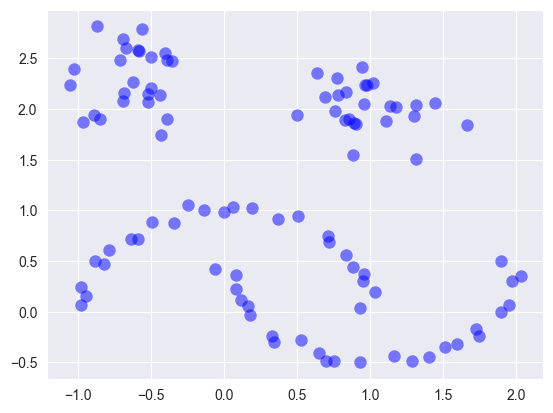

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data[:, 0], test_data[:, 1], color='b', **plot_kwds)
plt.show()

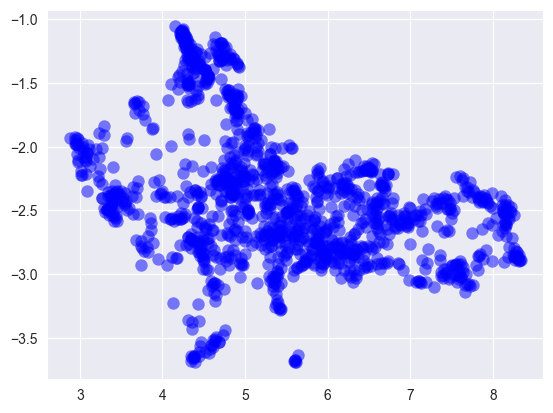

In [185]:
sample = len(reduced_embeddings)
component_1 = reduced_embeddings[:sample, 0]  #sample 100 
component_2 = reduced_embeddings[:sample, 1]  #sample 100
test_data   = reduced_embeddings#[:sample, [0,1]]

plt.scatter(component_1, component_2, color='b', **plot_kwds)
plt.show()

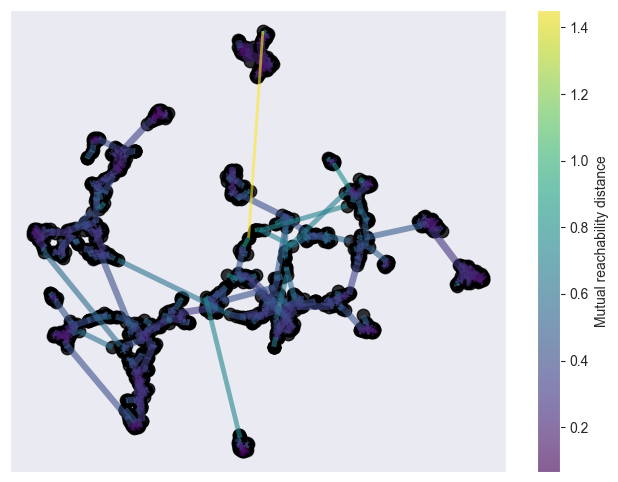

In [226]:
import hdbscan
#clusterer = hdbscan.HDBSCAN(min_cluster_size=15, 
#                            gen_min_span_tree=True)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, # 10 default
                            metric='euclidean',
                            cluster_selection_method='eom',
                            prediction_data=False,
                            gen_min_span_tree=True)

clusterer.fit(test_data)

plt.figure(figsize=(8, 6))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
plt.show()

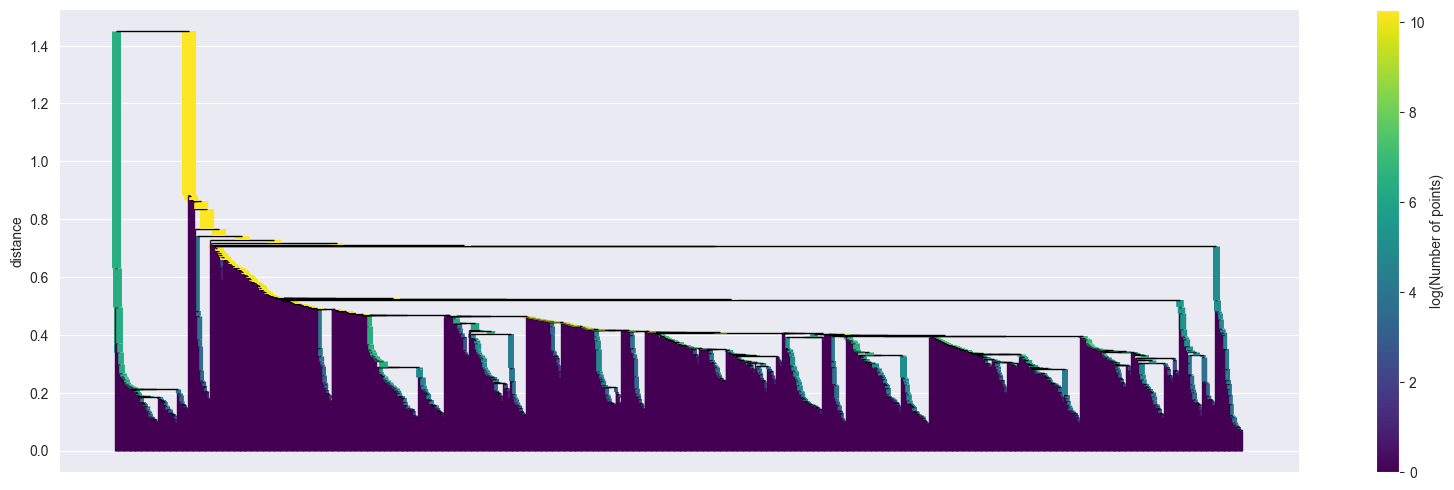

In [227]:
plt.figure(figsize=(20, 6))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

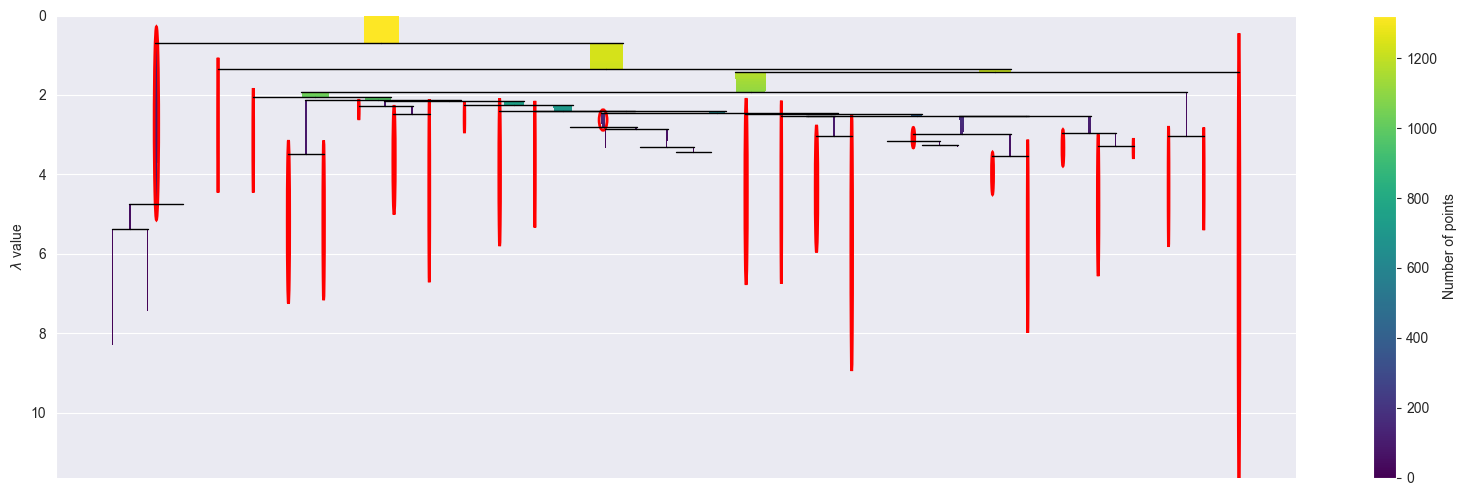

In [228]:
plt.figure(figsize=(20, 6))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

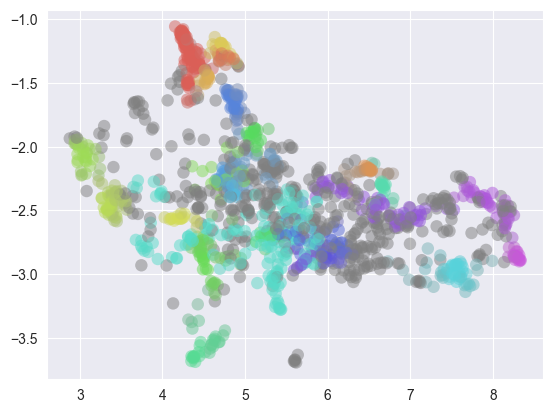

In [232]:
palette = sns.color_palette("hls", 30)

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(test_data[:, 0], test_data[:, 1], c=cluster_colors, **plot_kwds)

### Apply to BERTopic model

In [233]:
from hdbscan.hdbscan_ import HDBSCAN

# Find the optimal number of clusters with HDBscan
# Application: removing Noise
""" HDBSCAN: Hierarchical Density-Based Spatial Clustering of Applications with Noise """

hdbscan_model = HDBSCAN(min_cluster_size=10,   #BERTopic(min_topic_size = 10) #default
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=False)

topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       embedding_model = embedding_model)

topic_model_HBDSCAN = topic_model.fit(docs_preprocessed, embeddings)

get_topic_info(topic_model_HBDSCAN)

Topic  Count                                      Name  \
0      -1    437              -1_data_omics_multi_analysis   
1       0    150         0_data_omics_integration_analysis   
2       1     86                  1_cell_single_cells_data   
3       2     52               2_data_omics_learning_multi   
4       3     50            3_hcc_cancer_immune_expression   
5       4     47            4_clustering_cancer_data_multi   
6       5     46          5_methylation_genes_genetic_gwas   
7       6     46          6_microbiome_microbial_host_data   
8       7     39              7_cancer_deep_omics_learning   
9       8     36                 8_data_cancer_omics_multi   
10      9     33              9_ad_alzheimer_brain_disease   
11     10     33        10_lung_luad_adenocarcinoma_cancer   
12     11     32              11_plant_rice_csrnf217_maize   
13     12     31  12_gut_microbiota_microbiome_metabolites   
14     13     30             13_breast_cancer_gene_pathway   
15     14     19               14_graph_omics_cancer_multi   
16     15     19          15_cardiovascular_heart_hfpef_hf   
17     16     17          16_gbm_glioma_signature_analysis   
18     17     17               17_skin_eoe_ad_pathogenesis   
19     18     17              18_crc_colorectal_cancer_wnt   
20     19     16             19_asthma_copd_lung_pulmonary   
21     20     16       20_metabolic_models_flux_metabolism   
22     21     15          21_obesity_t2d_insulin_metabolic   
23     22     15                      22_covid_19_cov_sars   
24     23     13      23_regulatory_networks_gene_intomics   
25     24     11          24_hgsoc_ovarian_endometrial_age   

                                       Representation  \
0   [data, omics, multi, analysis, cancer, integra...   
1   [data, omics, integration, analysis, multi, me...   
2   [cell, single, cells, data, seq, multimodal, o...   
3   [data, omics, learning, multi, ai, machine, in...   
4   [hcc, cancer, immune, expression, genes, carci...   
5   [clustering, cancer, data, multi, subtypes, si...   
6   [methylation, genes, genetic, gwas, dna, gene,...   
7   [microbiome, microbial, host, data, multi, mic...   
8   [cancer, deep, omics, learning, data, multi, c...   
9   [data, cancer, omics, multi, analysis, integra...   
10  [ad, alzheimer, brain, disease, data, omics, m...   
11  [lung, luad, adenocarcinoma, cancer, nsclc, su...   
12  [plant, rice, csrnf217, maize, plants, express...   
13  [gut, microbiota, microbiome, metabolites, fec...   
14  [breast, cancer, gene, pathway, pathways, expr...   
15  [graph, omics, cancer, multi, classification, ...   
16  [cardiovascular, heart, hfpef, hf, mi, cvd, fa...   
17  [gbm, glioma, signature, analysis, patients, g...   
18  [skin, eoe, ad, pathogenesis, sle, immune, ra,...   
19  [crc, colorectal, cancer, wnt, cnvs, immune, e...   
20  [asthma, copd, lung, pulmonary, disease, ipf, ...   
21  [metabolic, models, flux, metabolism, model, s...   
22  [obesity, t2d, insulin, metabolic, aging, adip...   
23  [covid, 19, cov, sars, influenza, virus, vacci...   
24  [regulatory, networks, gene, intomics, biologi...   
25  [hgsoc, ovarian, endometrial, age, cancer, ec,...   

                                  Representative_Docs  
0   [integrative analysis multi-omics data discove...  
1   [integrated enrichment analysis pathway-center...  
2   [computational strategies single-cell multi-om...  
3   [integrated multi-omics analyses oncology : re...  
4   [whole genome RNA sequencing analyses 254 taiw...  
5   [multi-omics data fusion using adaptive GTO gu...  
6   [gene-methylation interactions : discovering r...  
7   [computational approaches integrative analysis...  
8   [classifying breast cancer subtypes using deep...  
9   [IOAT : interactive tool statistical analysis ...  
10  [harnessing endophenotypes network medicine al...  
11  [predictive signatures lung adenocarcinoma pro...  
12  [CARMO : comprehensive annotation platform fun...  
13  [

## 4. Topic Representation

In topic modeling, the quality of the topic representations is key for interpreting the topics, communicating results, and understanding patterns. It is of utmost importance to make sure that the topic representations fit with your use case.

### CountVectorizer

CountVectorizer operates by tokenizing the text data and counting the occurrences of each token. It then creates a matrix where the rows represent the documents, and the columns represent the tokens. The cell values indicate the frequency of each token in each document. This matrix is known as the “document-term matrix.”

In the example, the fit_transform method of CountVectorizer both fits the vectorizer to the documents (learns the vocabulary) and transforms the documents into a document-term matrix. The resulting matrix represents the frequency of each token in each document.

https://spotintelligence.com/2023/05/17/countvectorizer/#:~:text=CountVectorizer%20is%20a%20text%20preprocessing,machine%20learning%20library%20in%20Python.

In [261]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(corpus)

# Get the feature names (tokens)
feature_names = vectorizer.get_feature_names_out()

# Print the feature names
print(feature_names)

# Print the document-term matrix
print(X.toarray())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [269]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
print(X.toarray())

['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [270]:
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
print(X.toarray())

['document' 'second']
[[1 0]
 [2 1]
 [0 0]
 [1 0]]


### Apply to BERTopic model

In [266]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Train BERTopic with a custom CountVectorizer
vectorizer_model = CountVectorizer(min_df=10,
                                   stop_words="english")

topic_model = BERTopic(vectorizer_model=vectorizer_model,
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       embedding_model = embedding_model
                       )
#topic_model_vector = topic_model.fit(docs_preprocessed, embeddings)
topic_model_vector = topic_model.fit(docs, embeddings_docs)

get_topic_info(topic_model_vector)

Topic  Count                                          Name  \
0      -1    387                  -1_data_omics_multi_analysis   
1       0    103      0_microbiome_host_metabolites_metabolome   
2       1     78                       1_cell_single_cells_seq   
3       2     61                    2_lung_immune_cancer_tumor   
4       3     48       3_clustering_cancer_subtypes_similarity   
5       4     48           4_immune_disease_omics_pathogenesis   
6       5     46            5_medicine_precision_learning_data   
7       6     40                6_traits_expression_genes_data   
8       7     34               7_deep_cancer_learning_subtypes   
9       8     32         8_integration_data_biological_systems   
10      9     32         9_visualization_network_networks_maps   
11     10     32              10_methylation_dna_genetic_genes   
12     11     29            11_disease_omics_analysis_diseases   
13     12     26   12_networks_regulatory_biological_inference   
14     13     24                 13_disease_brain_drug_network   
15     14     23                    14_19_immune_blood_disease   
16     15     23        15_cancer_prognostic_targets_molecular   
17     16     22               16_pathways_modules_cancer_gene   
18     17     21        17_metabolomics_protocol_data_analysis   
19     18     20         18_variable_analysis_sparse_variables   
20     19     20         19_stress_exposure_effects_metabolism   
21     20     20               20_liver_carcinoma_immune_genes   
22     21     18                     21_cancer_data_tcga_omics   
23     22     17          22_metabolic_models_scale_metabolism   
24     23     15          23_cancer_age_alterations_associated   
25     24     15               24_graph_cancer_attention_omics   
26     25     14                25_resources_database_data_web   
27     26     14       26_signature_patients_risk_glioblastoma   
28     27     13              27_drug_deep_learning_prediction   
29     28     13               28_gwas_association_traits_snps   
30     29     13                29_breast_cancer_subtypes_gene   
31     30     11          30_plasma_lipid_metabolic_identified   
32     31     11  31_chromatin_stem_differentiation_regulatory   

                                       Representation  \
0   [data, omics, multi, analysis, cancer, integra...   
1   [microbiome, host, metabolites, metabolome, ac...   
2   [cell, single, cells, seq, data, datasets, omi...   
3   [lung, immune, cancer, tumor, expression, gene...   
4   [clustering, cancer, subtypes, similarity, dat...   
5   [immune, disease, omics, pathogenesis, systemi...   
6   [medicine, precision, learning, data, machine,...   
7   [traits, expression, genes, data, omics, gene,...   
8   [deep, cancer, learning, subtypes, data, multi...   
9   [integration, data, biological, systems, omics...   
10  [visualization, network, networks, maps, web, ...   
11  [methylation, dna, genetic, genes, gene, assoc...   
12  [disease, omics, analysis, diseases, risk, net...   
13  [networks, regulatory, biological, inference, ...   
14  [disease, brain, drug, network, molecular, gen...   
15  [19, immune, blood, disease, systems, approach...   
16  [cancer, prognostic, targets, molecular, patie...   
17  [pathways, modules, cancer, gene, driver, path...   
18  [metabolomics, protocol, data, analysis, metab...   
19  [variable, analysis, sparse, variables, data, ...   
20  [stress, exposure, effects, metabolism, pathwa...   
21  [liver, carcinoma, immune, genes, mutations, c...   
22  [cancer, data, tcga, omics, clinical, resource...   
23  [metabolic, models, scale, metabolism, model, ...   
24  [cancer, age, alterations, associated, cancers...   
25  [graph, cancer, attention, omics, classificati...   
26  [resources, database, data, web, visualization...   
27  [signature, patients, risk, glioblastoma, immu...   
28  [drug, deep, learning, prediction, neural, omi...   
29  [gwas, association, traits, snps, trait, stud

In [271]:
# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words="english", 
                                   ngram_range=(1, 3), 
                                   min_df=10)
topic_model_vector.update_topics(docs, vectorizer_model=vectorizer_model)
get_topic_info(topic_model_vector)

Topic  Count                                               Name  \
0      -1    387                    -1_data_omics_multi_multi omics   
1       0    103           0_microbiome_host_metabolites_metabolome   
2       1     78                    1_single cell_cell_single_cells   
3       2     61                         2_lung_immune_cancer_tumor   
4       3     48                  3_clustering_cancer_subtypes_data   
5       4     48                4_immune_omics_disease_pathogenesis   
6       5     46                 5_medicine_data_precision_learning   
7       6     40                     6_traits_data_omics_expression   
8       7     34                    7_deep_cancer_learning_subtypes   
9       8     32     8_integration_data_data integration_biological   
10      9     32              9_visualization_network_networks_maps   
11     10     32         10_methylation_dna_dna methylation_genetic   
12     11     29                 11_disease_omics_analysis_diseases   
13     12     26  12_networks_regulatory_regulatory networks_bio...   
14     13     24                      13_disease_brain_drug_network   
15     14     23                         14_19_immune_disease_blood   
16     15     23            15_cancer_prognostic_molecular_analysis   
17     16     22                    16_pathways_cancer_modules_gene   
18     17     21    17_metabolomics_metabolomics data_data_analysis   
19     18     20                   18_analysis_variable_data_sparse   
20     19     20              19_stress_exposure_effects_metabolism   
21     20     20                    20_liver_carcinoma_immune_genes   
22     21     18                          21_cancer_data_tcga_omics   
23     22     17               22_metabolic_models_scale_metabolism   
24     23     15               23_cancer_age_associated_alterations   
25     24     15                    24_graph_cancer_omics_attention   
26     25     14                     25_resources_data_database_web   
27     26     14                  26_signature_patients_risk_immune   
28     27     13                   27_drug_deep_learning_prediction   
29     28     13                    28_gwas_association_traits_snps   
30     29     13            29_breast_breast cancer_cancer_subtypes   
31     30     11               30_plasma_lipid_metabolic_identified   
32     31     11       31_chromatin_stem_differentiation_regulatory   

                                       Representation  \
0   [data, omics, multi, multi omics, omics data, ...   
1   [microbiome, host, metabolites, metabolome, ac...   
2   [single cell, cell, single, cells, seq, data, ...   
3   [lung, immune, cancer, tumor, expression, gene...   
4   [clustering, cancer, subtypes, data, similarit...   
5   [immune, omics, disease, pathogenesis, multi, ...   
6   [medicine, data, precision, learning, machine ...   
7   [traits, data, omics, expression, genes, gene,...   
8   [deep, cancer, learning, subtypes, omics data,...   
9   [integration, data, data integration, biologic...   
10  [visualization, network, networks, maps, omics...   
11  [methylation, dna, dna methylation, genetic, g...   
12  [disease, omics, analysis, diseases, network, ...   
13  [networks, regulatory, regulatory networks, bi...   
14  [disease, brain, drug, network, molecular, gen...   
15  [19, immune, disease, blood, systems, approach...   
16  [cancer, prognostic, molecular, analysis, gene...   
17  [pathways, cancer, modules, gene, driver, path...   
18  [metabolomics, metabolomics data, data, analys...   
19  [analysis, variable, data, sparse, variables, ...   
20  [stress, exposure, effects, metabolism, pathwa...   
21  [liver, carcinoma, immune, genes, mutations, c...   
22  [cancer, data, tcga, omics, clinical, multi om...   
23  [metabolic, models, scale, metabolism, model, ...   
24  [cancer, age, associated, alterations, cancers...   
25  [graph, cancer, omics, attention, classificati...   
26  [resources, data, database, web, visualization

## 5. c-TF-IDF

### TfidfVectorizer
TfidfVectorizer stands for “Term Frequency-Inverse Document Frequency Vectorizer.” It builds upon the concept of CountVectorizer but incorporates the TF-IDF weighting scheme. TF-IDF is a numerical statistic that reflects the importance of a term (token) in a document within a larger corpus.

The TF-IDF value for a term in a document is calculated by multiplying the term frequency (TF) and inverse document frequency (IDF) components:

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

Where:
1. Term Frequency (TF) = (Number of times term appears in a document) / (Total terms in the document)
2. Inverse Document Frequency (IDF) = log((Total number of documents) / (Number of documents containing the term)) 

- Term Frequency (TF) represents the frequency of a term in a document. It is typically calculated as the count of the term in the document divided by the total number of terms in the document.
- Inverse Document Frequency (IDF) measures the rarity of a term in the corpus. It is calculated as the logarithm of the total number of documents divided by the number of documents that contain the term.


In [280]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]


count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(corpus)

# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Get the feature names (tokens)
feature_names_count = count_vectorizer.get_feature_names_out()
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Print the feature names
print("CountVectorizer feature names:", feature_names_count)
print("TfidfVectorizer feature names:", feature_names_tfidf)

# Print the document-term matrices
print("\nCountVectorizer document-term matrix:")
print(X_count.toarray())

print("\nTfidfVectorizer document-term matrix:")
X_tfidf.toarray()

CountVectorizer feature names: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
TfidfVectorizer feature names: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']

CountVectorizer document-term matrix:
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]

TfidfVectorizer document-term matrix:


array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

c-TF-IDF
In BERTopic, in order to get an accurate representation of the topics from our bag-of-words matrix, TF-IDF was adjusted to work on a cluster/categorical/topic level instead of a document level. This adjusted TF-IDF representation is called c-TF-IDF and takes into account what makes the documents in one cluster different from documents in another cluster
Each cluster is converted to a single document instead of a set of documents. Then, we extract the frequency of word x in class c, where c refers to the cluster we created before. This results in our class-based tf representation. 

### Apply to BERTopic model

Some words appear quite often in every topic but are generally not considered stop words as found in the CountVectorizer(stop_words="english") list. To further reduce these frequent words, we can use reduce_frequent_words to take the square root of the term frequency after applying the weighting scheme.

In [301]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(ctfidf_model=ctfidf_model, 
                       vectorizer_model=vectorizer_model,
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       embedding_model = embedding_model
                       )
#topic_model_vector = topic_model.fit(docs_preprocessed, embeddings)
topic_model_vector = topic_model.fit(docs, embeddings_docs)

get_topic_info(topic_model_vector)

Topic  Count                                               Name  \
0      -1    387                   -1_mirna_prediction_mirnas_human   
1       0    103           0_microbiome_host_metabolites_metabolome   
2       1     78                       1_single_cell_modalities_seq   
3       2     61                     2_lung_immune_prognostic_tumor   
4       3     48         3_clustering_similarity_subtyping_subtypes   
5       4     48    4_systemic_pathogenesis_epithelial_inflammatory   
6       5     46            5_precision_medicine_artificial_machine   
7       6     40                 6_traits_trait_growth_biosynthesis   
8       7     34                   7_deep_subtype_subtypes_learning   
9       8     32              8_systems_management_integration_flow   
10      9     32                  9_visualization_maps_web_platform   
11     10     32                  10_methylation_loci_disorders_dna   
12     11     29                    11_mice_plasma_events_transport   
13     12     26             12_networks_regulatory_inference_prior   
14     13     24                       13_brain_disease_drug_module   
15     14     23                            14_19_blood_immune_host   
16     15     23                      15_prognostic_targets_95_copy   
17     16     22                 16_modules_driver_pathways_pathway   
18     17     21         17_metabolomics_protocol_basic_metabolites   
19     18     20             18_variable_sparse_variables_reduction   
20     19     20             19_stress_exposure_effects_biochemical   
21     20     20            20_liver_carcinoma_mutations_resistance   
22     21     18                        21_tcga_resources_easy_tool   
23     22     17        22_metabolic_models_production_optimization   
24     23     15                23_age_repair_cancers_tumorigenesis   
25     24     15  24_graph_attention_representations_classification   
26     25     14            25_resources_database_web_visualization   
27     26     14           26_signature_glioblastoma_prognosis_risk   
28     27     13                       27_drug_deep_neural_learning   
29     28     13                          28_gwas_snps_trait_traits   
30     29     13              29_breast_epigenomic_somatic_invasive   
31     30     11                     30_plasma_lipid_subjects_liver   
32     31     11    31_stem_chromatin_differentiation_accessibility   

                                       Representation  \
0   [mirna, prediction, mirnas, human, genomic, ex...   
1   [microbiome, host, metabolites, metabolome, ac...   
2   [single, cell, modalities, seq, cells, spatial...   
3   [lung, immune, prognostic, tumor, prognosis, s...   
4   [clustering, similarity, subtyping, subtypes, ...   
5   [systemic, pathogenesis, epithelial, inflammat...   
6   [precision, medicine, artificial, machine, lea...   
7   [traits, trait, growth, biosynthesis, species,...   
8   [deep, subtype, subtypes, learning, feature, c...   
9   [systems, management, integration, flow, biolo...   
10  [visualization, maps, web, platform, networks,...   
11  [methylation, loci, disorders, dna, sites, gen...   
12  [mice, plasma, events, transport, proteomics, ...   
13  [networks, regulatory, inference, prior, causa...   
14  [brain, disease, drug, module, subjects, drugs...   
15  [19, blood, immune, host, systems, response, r...   
16  [prognostic, targets, 95, copy, therapeutic, r...   
17  [modules, driver, pathways, pathway, breast, g...   
18  [metabolomics, protocol, basic, metabolites, m...   
19  [variable, sparse, variables, reduction, dimen...   
20  [stress, exposure, effects, biochemical, organ...   
21  [liver, carcinoma, mutations, resistance, alte...   
22  [tcga, resources, easy, tool, cancer, online, ...   
23  [metabolic, models, production, optimization, ...   
24  [age, repair, cancers, tumorigenesis, alterati...   
25  [graph, attention, representations, classifica...   
26  [resources, database, web, visualization, user

In [308]:
topic_model_vector.get_topic(1)

[('single', 0.4103431370143082),
 ('cell', 0.37844207723563833),
 ('modalities', 0.3021540319893969),
 ('seq', 0.2963937770879861),
 ('cells', 0.2776907530552876),
 ('spatial', 0.25860041958609153),
 ('heterogeneity', 0.2540106705886074),
 ('cellular', 0.23692141713211273),
 ('sequencing', 0.2352606487186189),
 ('datasets', 0.23012141180620144)]

## 6. Fine-tune Topic Representations

### KeyBERTInspired¶
After having generated our topics with c-TF-IDF, we might want to do some fine-tuning based on the semantic relationship between keywords/keyphrases and the set of documents in each topic. Although we can use a centroid-based technique for this, it can be costly and does not take the structure of a cluster into account. Instead, we leverage c-TF-IDF to create a set of representative documents per topic and use those as our updated topic embedding. Then, we calculate the similarity between candidate keywords and the topic embedding using the same embedding model that embedded the documents.

https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired

In [325]:
%%time
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model,
                       #ctfidf_model=ctfidf_model,
                       #vectorizer_model=vectorizer_model,
                       #hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       embedding_model=embedding_model)

# Apply to un processed corpus
topic_model_inspired = topic_model.fit(docs, embeddings_docs)

get_topic_info(topic_model_inspired)

CPU times: total: 22.4 s
Wall time: 27 s


Topic  Count                                               Name  \
0      -1    387                 -1_biomarkers_genomic_genome_omics   
1       0    103   0_metabolomics_microbiome_microbiota_microbiomes   
2       1     78          1_transcriptome_transcriptomic_cell_cells   
3       2     61        2_biomarkers_epigenetic_methylation_cancers   
4       3     48           3_clustering_cluster_clusters_clustomics   
5       4     48    4_metabolomics_asthma_biomarkers_transcriptomic   
6       5     46      5_bioinformatics_genomics_oncology_biomedical   
7       6     40       6_transcriptomic_metabolomics_genomic_plants   
8       7     34  7_autoencoders_autoencoder_classification_clas...   
9       8     32   8_bioinformatics_transcriptomics_multiomic_omics   
10      9     32         9_graphomics_omicsnet_mergeomics_mibiomics   
11     10     32    10_epigenetic_transcriptomic_methylation_genome   
12     11     29  11_metabolomics_proteomics_biomarkers_cardiova...   
13     12     26                 12_gene_datasets_genetic_inferring   
14     13     24          13_alzheimer_neurodegenerative_amyloid_aβ   
15     14     23                14_coronavirus_covid_sars_influenza   
16     15     23            15_lncrnas_biomarkers_colorectal_cancer   
17     16     22                16_genomic_pathway_cancers_pathways   
18     17     21  17_metabolomics_metabolomic_metabolites_proteo...   
19     18     20             18_multivariate_datasets_omics_dataset   
20     19     20  19_toxicogenomics_metabolomic_metabolome_toxic...   
21     20     20       20_hepatocellular_genomic_circrnas_carcinoma   
22     21     18   21_transcriptome_genomic_proteogenomics_genomics   
23     22     17  22_metabolomics_transcriptomics_metabolic_meta...   
24     23     15          23_genomic_tumorigenesis_epigenetic_ecdna   
25     24     15     24_embedding_biomarkers_cancers_classification   
26     25     14              25_genomic_genomics_genome_biosamples   
27     26     14          26_glioblastoma_glioma_gliomas_biomarkers   
28     27     13           27_deepdrk_anticancer_predict_prediction   
29     28     13               28_genomic_genome_phenotype_genotype   
30     29     13           29_epigenomic_genomic_methylation_cancer   
31     30     11            30_lipid_cholesterol_adipocytes_obesity   
32     31     11     31_transcriptomics_chromatin_epigenetic_genome   

                                       Representation  \
0   [biomarkers, genomic, genome, omics, rna, canc...   
1   [metabolomics, microbiome, microbiota, microbi...   
2   [transcriptome, transcriptomic, cell, cells, c...   
3   [biomarkers, epigenetic, methylation, cancers,...   
4   [clustering, cluster, clusters, clustomics, si...   
5   [metabolomics, asthma, biomarkers, transcripto...   
6   [bioinformatics, genomics, oncology, biomedica...   
7   [transcriptomic, metabolomics, genomic, plants...   
8   [autoencoders, autoencoder, classification, cl...   
9   [bioinformatics, transcriptomics, multiomic, o...   
10  [graphomics, omicsnet, mergeomics, mibiomics, ...   
11  [epigenetic, transcriptomic, methylation, geno...   
12  [metabolomics, proteomics, biomarkers, cardiov...   
13  [gene, datasets, genetic, inferring, molecular...   
14  [alzheimer, neurodegenerative, amyloid, aβ, mi...   
15  [coronavirus, covid, sars, influenza, immunolo...   
16  [lncrnas, biomarkers, colorectal, cancer, rna,...   
17  [genomic, pathway, cancers, pathways, cancer, ...   
18  [metabolomics, metabolomic, metabolites, prote...   
19  [multivariate, datasets, omics, dataset, class...   
20  [toxicogenomics, metabolomic, metabolome, toxi...   
21  [hepatocellular, genomic, circrnas, carcinoma,...   
22  [transcriptome, genomic, proteogenomics, genom...   
23  [metabolomics, transcriptomics, metabolic, met...   
24  [genomic, tumorigenesis, epigenetic, ecdna, ov...   
25  [embedding, biomarkers, cancers, classificatio...   
26  [genomic, genomics, genome, biosamples, gene, 

In [327]:
%%time
topic_model = BERTopic(embedding_model = embedding_model,
                       umap_model=umap_model,)
topic_model_base = topic_model.fit(docs, embeddings=embeddings_docs)

get_topic_info(topic_model_base)

CPU times: total: 8.64 s
Wall time: 12.9 s


Topic  Count                                          Name  \
0      -1    387                              -1_the_of_and_in   
1       0    103               0_microbiome_and_gut_microbiota   
2       1     78                        1_cell_single_the_data   
3       2     61                        2_lung_cancer_and_luad   
4       3     48             3_clustering_cancer_data_subtypes   
5       4     48                            4_and_asthma_of_in   
6       5     46                             5_the_of_and_data   
7       6     40                            6_plant_the_in_and   
8       7     34                        7_deep_cancer_the_data   
9       8     32                     8_integration_data_of_the   
10      9     32               9_visualization_and_network_the   
11     10     32                     10_methylation_and_of_dna   
12     11     29               11_and_heart_cardiovascular_the   
13     12     26                12_networks_regulatory_data_of   
14     13     24                   13_ad_alzheimer_disease_and   
15     14     23                       14_covid_19_vaccine_and   
16     15     23                  15_crc_colorectal_cancer_and   
17     16     22               16_cancer_pathways_modules_gene   
18     17     21                   17_metabolomics_of_data_the   
19     18     20                       18_analysis_data_of_the   
20     19     20                     19_the_stress_of_exposure   
21     20     20         20_hcc_liver_hepatocellular_carcinoma   
22     21     18                       21_cancer_data_tcga_and   
23     22     17                  22_metabolic_models_the_flux   
24     23     15                   23_hgsoc_ovarian_cancer_hpv   
25     24     15                   24_graph_cancer_omics_multi   
26     25     14          25_data_resources_kbcommons_database   
27     26     14                   26_gbm_glioma_signature_and   
28     27     13                   27_drug_deep_learning_omics   
29     28     13                28_gwas_of_association_studies   
30     29     13                     29_breast_cancer_tnbc_the   
31     30     11                   30_obesity_plasma_lipid_and   
32     31     11  31_chromatin_stem_differentiation_regulatory   

                                       Representation  \
0   [the, of, and, in, to, data, omics, for, multi...   
1   [microbiome, and, gut, microbiota, the, in, of...   
2   [cell, single, the, data, cells, multimodal, o...   
3   [lung, cancer, and, luad, immune, in, of, the,...   
4   [clustering, cancer, data, subtypes, the, to, ...   
5   [and, asthma, of, in, the, copd, to, immune, w...   
6   [the, of, and, data, in, to, medicine, learnin...   
7   [plant, the, in, and, of, to, rice, plants, ma...   
8   [deep, cancer, the, data, autoencoder, learnin...   
9   [integration, data, of, the, omics, biological...   
10  [visualization, and, network, the, of, to, omi...   
11  [methylation, and, of, dna, the, in, to, genes...   
12  [and, heart, cardiovascular, the, of, in, hfpe...   
13  [networks, regulatory, data, of, to, biologica...   
14  [ad, alzheimer, disease, and, brain, of, the, ...   
15  [covid, 19, vaccine, and, cov, sars, influenza...   
16  [crc, colorectal, cancer, and, of, in, the, gc...   
17  [cancer, pathways, modules, gene, the, pathway...   
18  [metabolomics, of, data, the, and, analysis, t...   
19  [analysis, data, of, the, variable, omics, for...   
20  [the, stress, of, exposure, and, to, in, toxic...   
21  [hcc, liver, hepatocellular, carcinoma, in, we...   
22  [cancer, data, tcga, and, of, to, the, omics, ...   
23  [metabolic, models, the, flux, of, to, scale, ...   
24  [hgsoc, ovarian, cancer, hpv, with, of, and, t...   
25  [graph, cancer, omics, multi, the, convolution...   
26  [data, resources, kbcommons, database, and, we...   
27  [gbm, glioma, signature, and, patients, analys...   
28  [drug, deep, learning, omics, prediction, anti...   
29  [gwas, of, association, studies, traits, to, 

### MaximalMarginalRelevance
To decrease this redundancy and improve the diversity of keywords, we can use an algorithm called Maximal Marginal Relevance (MMR). MMR considers the similarity of keywords/keyphrases with the document, along with the similarity of already selected keywords and keyphrases. This results in a selection of keywords that maximize their within diversity with respect to the document.

In [326]:
%%time
from bertopic.representation import MaximalMarginalRelevance
# Fine-tune your topic representations
representation_model = MaximalMarginalRelevance()

# Apply to un processed corpus
topic_model = BERTopic(representation_model=representation_model,
                       umap_model=umap_model,
                       embedding_model=embedding_model)
topic_model_mmr = topic_model.fit(docs, embeddings_docs)

get_topic_info(topic_model_mmr)

CPU times: total: 15.7 s
Wall time: 14.9 s


Topic  Count                                           Name  \
0      -1    387                   -1_data_omics_multi_analysis   
1       0    103  0_microbiome_microbiota_microbial_metabolites   
2       1     78                  1_cell_cells_multimodal_omics   
3       2     61                      2_lung_cancer_luad_immune   
4       3     48             3_clustering_cancer_subtypes_multi   
5       4     48                     4_asthma_copd_immune_omics   
6       5     46                    5_of_data_medicine_learning   
7       6     40                      6_plant_rice_plants_maize   
8       7     34             7_deep_cancer_autoencoder_learning   
9       8     32               8_integration_data_omics_systems   
10      9     32         9_visualization_network_omics_networks   
11     10     32               10_methylation_dna_genes_genetic   
12     11     29               11_heart_cardiovascular_hfpef_hf   
13     12     26         12_networks_regulatory_data_biological   
14     13     24           13_alzheimer_brain_amyloid_cognitive   
15     14     23                      14_covid_vaccine_cov_sars   
16     15     23                    15_crc_colorectal_cancer_gc   
17     16     22                16_cancer_pathways_modules_gene   
18     17     21   17_metabolomics_analysis_metaboanalyst_omics   
19     18     20                 18_omics_sparse_variables_mcia   
20     19     20   19_toxicogenomics_pm2_toxicology_temperature   
21     20     20          20_hcc_liver_hepatocellular_carcinoma   
22     21     18            21_cancer_tcga_omics_proteogenomics   
23     22     17           22_metabolic_scale_metabolism_genome   
24     23     15                  23_ovarian_cancer_hpv_iprofun   
25     24     15        24_graph_cancer_convolutional_attention   
26     25     14  25_resources_kbcommons_database_visualization   
27     26     14                 26_gbm_glioma_signature_immune   
28     27     13                    27_drug_deep_learning_omics   
29     28     13                 28_gwas_association_omics_snps   
30     29     13                    29_breast_cancer_tnbc_pam50   
31     30     11                 30_obesity_lipid_hdl_metabolic   
32     31     11           31_chromatin_stem_pluripotency_cells   

                                       Representation  \
0   [data, omics, multi, analysis, cancer, integra...   
1   [microbiome, microbiota, microbial, metabolite...   
2   [cell, cells, multimodal, omics, seq, multi, d...   
3   [lung, cancer, luad, immune, tumor, prognostic...   
4   [clustering, cancer, subtypes, multi, similari...   
5   [asthma, copd, immune, omics, sle, disease, pa...   
6   [of, data, medicine, learning, precision, mult...   
7   [plant, rice, plants, maize, omics, genes, gen...   
8   [deep, cancer, autoencoder, learning, subtypes...   
9   [integration, data, omics, systems, methods, o...   
10  [visualization, network, omics, networks, merg...   
11  [methylation, dna, genes, genetic, disorder, g...   
12  [heart, cardiovascular, hfpef, hf, myocardial,...   
13  [networks, regulatory, data, biological, netwo...   
14  [alzheimer, brain, amyloid, cognitive, mci, mo...   
15  [covid, vaccine, cov, sars, influenza, virus, ...   
16  [crc, colorectal, cancer, gc, gastric, prognos...   
17  [cancer, pathways, modules, gene, pathway, dat...   
18  [metabolomics, analysis, metaboanalyst, omics,...   
19  [omics, sparse, variables, mcia, tensor, multi...   
20  [toxicogenomics, pm2, toxicology, temperature,...   
21  [hcc, liver, hepatocellular, carcinoma, cd73, ...   
22  [cancer, tcga, omics, proteogenomics, can, pat...   
23  [metabolic, scale, metabolism, genome, optimiz...   
24  [ovarian, cancer, hpv, iprofun, uf, cancers, e...   
25  [graph, cancer, convolutional, attention, clas...   
26  [resources, kbcommons, database, visualization...   
27  [gbm, glioma, signature, immune, prognosis, gl...   
28  [drug, deep, learning, omics, prediction, anti...   
29  [gwas, asso

In [329]:
n = 0
# Merge the three dataframes horizontally based on the index
merged_df = pd.concat([pd.DataFrame(topic_model_base.get_topic(n), columns=['base', 'base']),
                       pd.DataFrame(topic_model_vector.get_topic(n), columns=['vector', 'vector']),
                       pd.DataFrame(topic_model_inspired.get_topic(n), columns=['inspired', 'inspired']),
                       pd.DataFrame(topic_model_mmr.get_topic(n), columns=['mmr', 'mmr'])],
                       axis=1)

# Display the horizontally merged dataframe
merged_df

base      base        vector    vector      inspired  inspired  \
0  microbiome  0.032952    microbiome  0.419102  metabolomics  0.597405   
1         and  0.026988          host  0.332772    microbiome  0.596390   
2         gut  0.025635   metabolites  0.296840    microbiota  0.574704   
3  microbiota  0.024017    metabolome  0.292479   microbiomes  0.566992   
4         the  0.022406          acid  0.267779    metabolome  0.530603   
5          in  0.021542   composition  0.246951   metagenomic  0.508343   
6          of  0.020412         acids  0.240437     microbial  0.404461   
7   microbial  0.019953  inflammatory  0.227644   metabolites  0.401375   
8          to  0.017408            ms  0.223197     metabolic  0.341709   
9        host  0.016340        stress  0.221097      bacteria  0.335827   

           mmr       mmr  
0   microbiome  0.032952  
1   microbiota  0.024017  
2    microbial  0.019953  
3  metabolites  0.015639  
4   metabolome  0.011876  
5         acid  0.010629  
6          ibd  0.010165  
7        omics  0.010022  
8      disease  0.010014  
9        fecal  0.009870

## Assemble your custom BERTopic model

Custom settings
https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html

In [ ]:
import re
from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired


# Step 1 Extract embeddings (SBERT)
# ref: https://www.sbert.net/docs/pretrained_models.html 
models = ["allenai-specter", "all-mpnet-base-v2",  "all-MiniLM-L6-v2"]    
embedding_model = SentenceTransformer("allenai-specter") 


# Step 2 - Reduce dimensionality 
# uniform manifold approximation and projection (UMAP) to reduce the dimension of embeddings
random_state = 123456 
umap_model = UMAP(n_neighbors  = 15, #num of high dimensional neighbours. 
                  n_components = 5,  # default:5 
                  min_dist     = 0.0, 
                  random_state = random_state) # default:None


# Step 3 - Clusterize reduced embeddings 
min_cluster_size = 10 # default:5 HDBSCAN(), default:10 BERTopic()
hdbscan_model = HDBSCAN(min_cluster_size = min_cluster_size,
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True)


# Step 4 - Tokenize topics 
vectorizer_model = CountVectorizer(stop_words="english", lowercase=False) # lowercase=False to keep Acronyms uppercase


# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # False default


# Step 6 - Fine-tune topic representations with a bertopic.representation model
# Create your representation model
representation_model = MaximalMarginalRelevance(diversity = 0.7,  # 0.1 default
                                                top_n_words = 15) # 10 default
#representation_model = KeyBERTInspired()


# Use the representation model in BERTopic on top of the default pipeline

# All steps together
topic_model = BERTopic(
    min_topic_size = 10,                         # 10 default
    top_n_words = 15,                            # 10 default
    calculate_probabilities = True,
    embedding_model = sentence_transformer,      # Step 1 - Extract embeddings
    umap_model = umap_model,                     # Step 2 - Reduce dimensionality
    hdbscan_model = hdbscan_model,               # Step 3 - Cluster reduced embeddings
    vectorizer_model = vectorizer_model,         # Step 4 - Tokenize topics
    ctfidf_model = ctfidf_model,                 # Step 5 - Extract topic words
    representation_model= representation_model  # Step 6 - (Optional) Fine-tune topic represenations
)

In [ ]:
len(docs_processed)

## Fit Transform

In [ ]:
# Fit Transform
#topics, probs = topic_model.fit_transform(docs_processed)
#topics_fit = topic_model.fit(docs_processed)

In [ ]:
## If you want to split embedding phase, use it as follows:

# Step 1 Embedding documents with sentence_transformer
embedding_file = 'nbib_subset_clean_embeddings.txt'

if simple_bool('Load pre-generated embeddings?'):
    embeddings = np.loadtxt(data_path + embedding_file)
else:
    embeddings = sentence_transformer.encode(docs_processed,
                                       show_progress_bar=True)

# Get Topic Model using custom embeddings
topics, probs = topic_model.fit_transform(docs_processed, embeddings=embeddings)
#topics = topic_model.fit(docs_processed, embeddings=embeddings)
print('random_state:',random_state)

In [ ]:
print(embeddings.shape)
#embeddings_redux = umap_model.fit(embeddings)
#print(embeddings_redux.embedding_.shape)
topic_model.get_topic_info()

## Save Embeddings

In [ ]:
if simple_bool('save grpm_abs_embeddings?'):
    filename = 'nbib_subset_clean_'+str(mesh_count)+'_embeddings.txt'
    np.savetxt(data_path+filename, embeddings)

## Save/Load Model

In [ ]:
if simple_bool('Save topics model?'):
    filename= "nbib_subset_clean_"+str(mesh_count)+"_topicmodel_rndm"+str(random_state)
    topic_model.save(filename)
    np.savetxt(data_path+filename+'_probs.txt', probs)

In [ ]:
if simple_bool('Load topics model?'):
    filename = 'nbib_subset_nano_251_topicmodel_rndm1337_v2_iknos'
    topic_model = BERTopic.load(data_path+filename)
    probs = np.loadtxt(data_path+filename+'_probs.txt')

if 'docs_processed' not in globals():
    if simple_bool('load abs_preprocessed?'):
        docs_processed = load_preprocessed()

In [ ]:
display(topic_model.get_topic_info().head())
pd.DataFrame(probs).head()
#topic_model.get_document_info(docs_processed).Probability

## Custom Labels

In [ ]:
#basic custom labels 
topic_labels = topic_model.generate_topic_labels(nr_words     = 4,
                                                 topic_prefix = True,
                                                 word_length  = 10,
                                                 separator    = " ")
common_length = 30
padded_list = [s.ljust(common_length) + " "  if len(s) < common_length else s[:common_length] + " "  for s in topic_labels]
#padded_list = [s.replace(' ', ' ') for s in padded_list]

if simple_bool('use padded list?'):
    topic_labels = padded_list
    
topic_model.set_topic_labels(topic_labels)
topic_model.get_topic_info()#.head()

In [ ]:
# Return top n words for a specific topic and their c-TF-IDF scores
print('Top n words for a specific topic and their c-TF-IDF scores')
topic_id = 0
topic = topic_model.get_topic(topic_id, full=False)
pd.DataFrame(topic)#[1].sum()

## Topic Info

In [ ]:
# Return topics with top n words and their c-TF-IDF score
all_topics = topic_model.get_topics()
topic_df = pd.DataFrame(all_topics)#.T#.head()

# Probablities
probs_df = pd.DataFrame(probs)

# Topic FREQ
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq.Count[0]

print('total',topic_freq.Count.sum())
print('outliers',outliers)
print('ingroup',topic_freq.Count.sum()-outliers)

# Topic INFO
topic_info = topic_model.get_topic_info()
#print(topic_info.columns)
topic_info

In [ ]:
#mesh_count, random_state = 251,'v2',1337
if simple_bool('save topic info?'):
    filename = 'topic_info_'+str(mesh_count)+'_rndm'+str(random_state)+'.csv'
    topic_info.to_csv(data_path+filename)

## Document Info

In [ ]:
#topics_fit.get_document_info(docs_processed)
if 'docs_processed' not in locals():
    docs_processed = load_preprocessed()

doc_info = topic_model.get_document_info(docs_processed)
doc_info['pubmed_id'] = doc_info.Document.str.split(' $ ').str[0].str.split().str[0]
doc_info['Abstract']  = doc_info.Document.str.split('$').str[1]

doc_info_s = doc_info[['Topic','pubmed_id', 'Abstract', 'Name', 'Representation', 'Top_n_words', 'Probability','Representative_document']]

print(doc_info.columns)
doc_info_s[doc_info_s.Topic == 1].reset_index().sort_values(by='index').head()#.T

In [ ]:
if simple_bool('Save document info?'):
    filename = 'doc_info_'+str(mesh_count)+'_rndm'+str(random_state)+'.csv'
    doc_info.to_csv(data_path+filename)

In [ ]:
if simple_bool('Load document info?'):
    doc_info = pd.read_csv('data/doc_info_251_rndm1337.csv', index_col=0)
doc_info

## Get PMID and Genes

In [ ]:
# get pubmed_id per topic
def get_pmids(topic_id):
    len(doc_info[doc_info.Topic == topic_id])
    doc_topic = doc_info[doc_info.Topic == topic_id]
    pmid_topic = doc_topic.pubmed_id.reset_index(drop=True).astype(str)
    return pmid_topic

#get gene per topic
def get_genes(topic_id):
    genes_topic = grpm_dataset[grpm_dataset['pmids'].isin(get_pmids(topic_id))].gene.drop_duplicates().reset_index(drop=True)
    return genes_topic

if 'grpm_dataset' not in globals():
    grpm_dataset = pd.read_csv("grpm_dataset/grpm_db_pcg/grpm_table_output.csv", index_col=0).reset_index(drop=True)
    grpm_dataset['pmids'] = grpm_dataset['pmids'].astype(str)
    
get_genes(2)

In [ ]:
# Get Representative Documents
print(topic_info['Representative_Docs'][1])
print('\n',topic_info['Representation'][1])

doc_info_s_rep = doc_info_s[doc_info_s.Representative_document==True]
doc_info_s_rep

In [ ]:
# Print the top n words for / c-TF-IDF scores for a specific topic (here the 0)
for n in range(2):
    print(pd.Series(topic_model.get_topic(n))) 

## Topic naming

### Generate names (GPT3.5)

In [ ]:
if not os.path.isfile('pychatgpt_lite.py'):
    get_gitfile('https://github.com/johndef64/pychatgpt/blob/main/pychatgpt_lite.py')

import pychatgpt_lite as op
op.expand_chat('''You are an helpful scientific assistant''', 'system')

topic_info['CustomLabel_GPT3.5'] = ''
free_user = False

gpt_label = 'a short label of the topic. Reply only with the result.'
gpt_description = 'a short but accurate description of the topic. Reply only with the result.'

op.clearchat()
def generate(what, label):
    for i in range(len(topic_info)):
        prompt1 = ''' 
        Using your knowledge of biomendical science, give a short, appropriate and specific name to the topic describing the following list of biomedical terms, max 8 words. 
        '''+str(topic_info.Representation.iloc[i])

        '''
        Example: 
        term list: 
        ['cell','mice','protein','levels','liver','lipid','role','plasma','inflammatory','activation','muscle','study','diseases','mutations','associated']
        outout: 
        "Role of Inflammatory Protein in Liver Diseases'"
        '''

        if len(doc_info[doc_info.Topic == i-1]) <=1:
            sample = 1
        elif len(doc_info[doc_info.Topic == i-1]) <=2:
            sample =2
        else:
            sample = 3

        sample_docs = str(doc_info[doc_info.Topic == i-1][doc_info.Representative_document == True].sample(sample).Abstract)

        prompt2 = """
        I have topic that contains the following documents: """ +sample_docs+ """
        The topic is described by the following keywords: """ +str(topic_info.Representation.iloc[i])+ """
        
        Based on the above information, give me """+what

        op.send_message(prompt2, model=op.model, printtoken= False, savechat=False)
        if label not in topic_info.columns:
            topic_info[label] = None
        topic_info[label][i] = str(i)+'.'+op.reply #topic_info['CustomLabel_GPT3.5'][i]

        if i>=3 and i % 20 == 0:
            print('\nsleeping... (61 sec)')
            time.sleep(61)

        if free_user:
            if i>=3 and i % 3 == 0:
                print('\nsleeping... (55 sec)')
                time.sleep(55)
        print('\n')

generate(gpt_label, 'CustomLabel_GPT3.5')
generate(gpt_description, 'Description_GPT3.5')

topic_labels_gpt = topic_info['CustomLabel_GPT3.5']
topic_info.head()

In [ ]:
if simple_bool('Save topic info GPT?'):
    filename = 'topic_info_'+str(mesh_count)+'_rndm'+str(random_state)+'_iknos_GPT.csv'
    topic_info.to_csv(data_path+filename)

if simple_bool('Load topic info GPT?'):
    topic_info = pd.read_csv(data_path+'topic_info_251_rndm1337_iknos_GPT.csv', index_col=0) 

topic_info[['Topic', 'Count', 'CustomLabel_GPT3.5','Representation']]#[17:].to_clipboard(index=False)#csv('table.csv')
#['CustomLabel_gpt-3.5'][0]

In [ ]:
latex_table = topic_info[['Topic', 'Count', 'CustomLabel_GPT3.5']].to_latex(index=False)
import pyperclip as pc
pc.copy(latex_table)

RPM (requests per minute) – The maximum requests allowed per minute  
RPD (requests per day) – The maximum requests allowed per da  

TPM (tokens per minute) – The maximum tokens allowed to be sent per minute

In [ ]:
data = {'TIER': ['Free', 'Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5'],
        'QUALIFICATION': ['User must be in an allowed geography', '$5 paid', '$50 paid and 7+ days since first successful payment','$100 paid and 7+ days since first successful payment', '$250 paid and 14+ days since first successful payment','$1000 paid and 30+ days since first successful payment'],
        'MAX CREDITS': ['$100', '$100', '$250', '$500', '$1000', '$1000'],
        'REQUEST LIMITS': ['3 RPM, 200 RPD', '500 RPM, 10K RPD', '5000 RPM', '5000 RPM', '10K RPM', '10K RPM'],
        'TOKEN LIMITS': ['10K TPM', '20K TPM', '40K TPM', '80K TPM', '300K TPM', '300K TPM']}
print('Openai API reference:')
pd.DataFrame(data)

-- GOAL: PMID clusering and topic definition ('openai')

### Set topic labels

In [ ]:
# basic custom labels 
topic_model.set_topic_labels(topic_labels)

In [ ]:
# gpt-3.5 custom labels 
topic_model.set_topic_labels(topic_labels_gpt.to_list())
topic_model.get_topic_info().head()

# topic_model.visualize_barchart(n_words=20, top_n_topics=4, custom_labels=True)  

# Topic Visualization¶

Topic Visualization¶
Evaluating topic models can be rather difficult due to the somewhat subjective nature of evaluation. Visualizing different aspects of the topic model helps in understanding the model and makes it easier to tweak the model to your liking.

| Method                                      | Code                                    |
|--------------------------------------------|-----------------------------------------|
| Visualize Topics                            | `.visualize_topics()`                     |
| Visualize Documents                         | `.visualize_documents()`                  |
| Visualize Document Hierarchy                | `.visualize_hierarchical_documents()`     |
| Visualize Topic Hierarchy                   | `.visualize_hierarchy()`                  |
| Visualize Topic Tree                        | `.get_topic_tree(hierarchical_topics)`    |
| Visualize Topic Terms                       | `.visualize_barchart()`                   |
| Visualize Topic Similarity                  | `.visualize_heatmap()`                    |
| Visualize Term Score Decline                | `.visualize_term_rank()`                  |
| Visualize Topic Probability Distribution    | `.visualize_distribution(probs[0])`       |
| Visualize Topics over Time                  | `.visualize_topics_over_time(topics_over_time)` |
| Visualize Topics per Class                  | `.visualize_topics_per_class(topics_per_class)` |

## Document visualization

In [ ]:
# visualize_documents (sample) ! Computationally intensive !

topic_model.set_topic_labels(topic_labels)
topic_model.visualize_documents(docs_processed, sample= 0.05, custom_labels=True)  
#topic_model.visualize_documents(docs_processed, embeddings=embeddings)

In [ ]:
# visualize_documents (sample) (using embeddings, faster)
if 'embeddings' not in locals():
    embedding_file = 'nbib_subset_clean_251_embeddings_v2.txt'
    embeddings = np.loadtxt(data_path+embedding_file)

topic_model.set_topic_labels(topic_labels)
topic_model.visualize_documents(docs_processed, embeddings=embeddings,sample= 0.1, custom_labels=False)

## Topic Visualization

### Intertopic Distance Map

After having trained our BERTopic model, we can iteratively go through hundreds of topics to get a good understanding of the topics that were extracted. However, that takes quite some time and lacks a global representation. Instead, we can visualize the topics that were generated in a way very similar to LDAvis.

We embed our c-TF-IDF representation of the topics in 2D using Umap and then visualize the two dimensions using plotly such that we can create an interactive view.

In [ ]:
topic_model.visualize_topics() #can help you visualize topics generated with their sizes and corresponding words.

# Post-processing

## Topic Evaluation
thanks to Topic Clusterization and Intertopic Distance Map 

Results:
- based on 251 Mesh, we retieverd 37.000 pepers from GRPM Dataset
- Topic Modeling on abstracts, we got 50 Topics
- Topic Evaluation, from 50 Topics to X0 topics
- from 37.000 paper to 10.238 papers, XX.000 excluded and 13.YYY outliers
- from 8.280 genes to 3.911 genes (cross papers with GRPM ds)
- get genes network for selected topics 

### Curated Topic Evaluation  

In [ ]:
pertinent_topics = [ 11,28,48,18,2,5,  #cluster1:
                     9,35, #cluster2
                     12,#cluster3
                     #cluster4
                     37,32,19,40,26,33, #cluster5
                     3,31,#cluster6
                     #cluster7
                     #cluster8
                     #cluster9
                     8,20,4,34#cluster10
                     ]

non_pertinent_topics = [ 27,47, #cluster1
                         1,#cluster2
                         0,30,21,49,36, #cluster3
                         39,13,#cluster3
                         16,39, #cluster4
                         #cluster5
                         29,#cluster6
                         45,25,7,44,24,23,14,#cluster7
                         38,50,46,10,42,17,#cluster8
                         41,6,16,15,43,22,#cluster9
                         #cluster10
                         ]
print('Selected Topics:')
topic_info[topic_info.Topic.isin(pertinent_topics)]

### Get Representative Docs

In [ ]:
#Get Representative_document abstracts for pertinent topics
doc_info_s_rep = doc_info_s[doc_info_s.Representative_document==True]
doc_info_s_rep_pert = doc_info_s_rep[doc_info_s_rep.Topic.isin(pertinent_topics)]
doc_info_s_rep_pert.Abstract.to_list()
#pc.copy(str(doc_info_s_rep_pert.Abstract.to_list()))
#pc.copy(str(doc_info_s_rep_pert.pubmed_id.to_list()))

In [ ]:
# visualize_documents (sample)
if 'embeddings' not in locals():
    embedding_file = 'nbib_subset_clean_251_embeddings_v2.txt'
    embeddings = np.loadtxt(data_path+embedding_file)
    
topic_model.set_topic_labels(topic_labels)
topic_model.visualize_documents(docs_processed, topics= pertinent_topics, embeddings=embeddings,sample= 0.1, custom_labels=False)

In [ ]:
# Evaluation Results
topic_info_pertinent = topic_info[['Topic', 'Count','CustomName', 'Representation']][topic_info.Topic.isin(pertinent_topics)]
doc_info_s_pertinent = doc_info_s[doc_info_s.Topic.isin(pertinent_topics)]

total_count = topic_info.Count.sum()
pertinent_count = topic_info_pertinent.Count.sum()
outliers = topic_info.Count[0]
non_pertinent_count = total_count-outliers-pertinent_count

print('total count:', total_count)
print('outliers count:', outliers)
print('non pertinent count:', non_pertinent_count)
print('pertinent count:', pertinent_count)
'''
import plotly.express as px
data = {
    'Type': ['Pertinent Count', 'Non-Pertinent Count', 'Outliers'],
    'Value': [pertinent_count, non_pertinent_count, outliers]
}
fig = px.treemap(data, path=['Type'], values='Value', title='Treemap')
fig.show()
'''
import matplotlib.pyplot as plt
import squarify
labels = ['Pertinent Count', 'Non-Pertinent Count', 'Outliers']
sizes = [pertinent_count, non_pertinent_count, outliers]
colors = ['green', 'red', 'grey']

plt.figure(figsize=(4, 4))  
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7)
#plt.axis('off')
#plt.title('Treemap')
plt.savefig('evaluation_placeholder.png', dpi=300)
plt.show()

topic_info_pertinent#.describe()

## Output Dataset 
### Output Dataset Stats

In [ ]:
filteres_grpm = grpm_dataset[grpm_dataset.mesh.isin(list_mesh)]
filteres_grpm = filteres_grpm[['gene', 'rsid', 'pmids', 'mesh']].drop_duplicates()
filteres_grpm.describe().to_clipboard()

pertinent_pmid = doc_info[doc_info.Topic.isin(pertinent_topics)].pubmed_id
modeled_grpm = grpm_dataset[grpm_dataset.pmids.isin(pertinent_pmid)]

print('Filtered by MeSH')
display(filteres_grpm.describe())
print('Selected by Topic')
display(modeled_grpm.describe())


### Get and Enrich Output Dataset

In [ ]:
output_ds = doc_info_s_pertinent[['Topic', 'pubmed_id', 'Abstract', 'Name', 'Representation']]

# filter NBIB
filterd_nbib = nbib_subset_clean[['pubmed_id','title','abstract', 'keywords', 'descriptors']].drop_duplicates()
filterd_nbib.pubmed_id = filterd_nbib.pubmed_id.astype(str)
output_nbib = filterd_nbib[filterd_nbib.pubmed_id.isin(output_ds.pubmed_id)]
output_nbib#.to_csv(data_path+'RAG_LLM_nutrigentic_dataset.csv')

# MERGE NBIB & TOPICS
output_ds_topic = pd.merge(output_ds[['Topic', 'pubmed_id', 'Name', 'Representation']], output_nbib, on='pubmed_id')
output_ds_topic.rename(columns={'Topic':'topic_id', 'pubmed_id':'pubmed_id', 'Name':'topic_name', 'Representation':'topic_representation'}, inplace=True)
output_ds_topic#.to_csv(data_path+'output_dataset_bertopic_nutrigentics.csv')

# MERGE NBIB-TOPICS & GENE-RSID
df = modeled_grpm[['gene', 'rsid', 'pmids']]
transformed_df = df.groupby('pmids').aggregate({'rsid': lambda x: list(x), 'gene': lambda x: list(x)}).reset_index()
transformed_df[['pmids', 'rsid', 'gene']]

output_ds_topic_gene_rsid = pd.merge(output_ds_topic, transformed_df, left_on='pubmed_id', right_on='pmids')
output_ds_topic_gene_rsid.rename(columns={'gene':'genes', 'rsid':'rsids'}, inplace=True)
output_ds_topic_gene_rsid.drop(columns='pmids', inplace=True)
output_ds_topic_gene_rsid = output_ds_topic_gene_rsid[['topic_id', 'pubmed_id', 'topic_name', 'topic_representation', 'title','abstract', 'keywords', 'descriptors', 'genes', 'rsids']]
output_ds_topic_gene_rsid#.to_csv(data_path+'output_dataset_bertopic_nutrigentics.csv')

### Load Enriched Output Dataset

In [ ]:
output_ds_topic_gene_rsid = pd.read_csv(data_path+'output_dataset_bertopic_nutrigenetics.csv', index_col=0)
output_ds_topic_gene_rsid

In [ ]:
# get enriched representative docs
topic_id = 2
doc_info_s_rep_pmid_bool = doc_info_s_rep[['pubmed_id', 'Representative_document']]
output_ds_topic_gene_rsid[output_ds_topic_gene_rsid.topic_id==topic_id]

# filter for representative docs
output_ds_topic_gene_rsid_rep = output_ds_topic_gene_rsid[output_ds_topic_gene_rsid.pubmed_id.isin(doc_info_s_rep_pmid_bool.pubmed_id)]
output_ds_topic_gene_rsid_rep[output_ds_topic_gene_rsid.topic_id==topic_id][['title','abstract','keywords']]

### Extras

In [ ]:
# to latex
df = topic_info[['Topic', 'Count', 'CustomLabel_GPT3.5']]
df['CustomLabel_GPT3.5']=df['CustomLabel_GPT3.5'].str.replace(r'^.*?\.', '', regex=True)
df_isin = df[df.Topic.isin(pertinent_topics)]

latex_table = df_isin.to_latex(index=False,caption='Pertinent Topics')
import pyperclip as pc
pc.copy(latex_table)

In [ ]:
# Return top n words for a specific topic and their c-TF-IDF scores
print('Top n words for a specific topic and their c-TF-IDF scores')
for topic_id in pertinent_topics:
    topic = topic_model.get_topic(topic_id, full=False)
    print('\n',topic_info.CustomName[topic_id])
    print(pd.DataFrame(topic))#[1].sum()

The argument with id -1 groups  all unattributed abstracts. We will ignore it.

# Display Results

### Visualize Probablities or Distribution¶


In [ ]:
# To visualize the probabilities of topic assignment
import plotly.graph_objects as go
fig = go.Figure()
for n in range(3):
    fig = topic_model.visualize_distribution(probs[n],
                                             min_probability = 0,
                                             custom_labels = False)
    fig.show()

In [ ]:
!pip install jinja2

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs_processed, calculate_tokens=True, min_similarity=0)

In [ ]:
# Visualize the token-level distributions
topic_n = 4
df = topic_model.visualize_approximate_distribution(docs_processed[topic_n], topic_token_distr[topic_n])
df

In [ ]:
topic_n = 2
doc_info[doc_info.Document == docs_processed[topic_n]].reset_index().sort_values(by='index')#.head()#.T

### Similarity Matrix
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
!pip install -U kaleido

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
def show_similarty(topics):
    fig = go.Figure()
    fig = topic_model.visualize_heatmap(topics=topics,
                                        top_n_topics = 51,
                                        #n_clusters = 20,
                                        custom_labels=True,
                                        width = 1100,
                                        height = 1100)
    #fig.write_image("fig1.png", engine='kaleido')
    fig.show()
    
show_similarty(None) # this is correct, in-line with the Intertopic distance map
#show_similarty(topic_info.Topic[:len(topic_info.Topic)-10]) # !!! reorder topic doesn't work
#show_similarty(hierarchy[:len(hierarchy)]) # !!! reorder topic doesn't work
#show_similarty(pertinent_topics) # !!! cherry-picking topics doesn't work
#show_similarty([7, 24,0,1,34,14,23]) 
#show_similarty([7, 14,20,14,3,4,2])
# Conclusion: the heatmap is fixed 

### Similarity Matrix (custom)

In [ ]:
pertinent_topics.sort()
pertinent_topics

In [ ]:
topic_info[topic_info.Topic.isin(pertinent_topics)].CustomName

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_)[1:, :])

# get labels
labels = topic_info[topic_info.Topic.isin(pertinent_topics)].CustomName
# Filter rows and columns based on indices
pertinent_topics.sort()
rows_to_keep = pertinent_topics
cols_to_keep = pertinent_topics
filtered_distance_matrix = distance_matrix[np.ix_(rows_to_keep, cols_to_keep)]

fig = px.imshow(filtered_distance_matrix,
                labels=dict(color="Similarity Score"),
                x=labels,
                y=labels,
                color_continuous_scale='GnBu'
                )
title: str = "<b>Similarity Matrix</b>"
fig.update_layout(
    title={
        'text': f"{title}",
        'y': .95,
        'x': 0.55,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="Black")
    },
    width=800,
    height=800,
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
)
fig.update_layout(showlegend=True)
fig.update_layout(legend_title_text='Trend')
fig.write_image("heatmap_short.png", engine="kaleido", scale=3)
fig.show()

## Hierarchy Visualization

### Hierarchical clustering

In [ ]:
topic_model.visualize_hierarchy(custom_labels=True, width=700, height=600) #The topics that were created can be hierarchically reduced.

### Hierarchical labels

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs_processed)
topic_model.visualize_hierarchy(custom_labels=True, width=700, height=600, hierarchical_topics=hierarchical_topics)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs_processed)
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

## Terms Visualization

### Wordclouds

In [ ]:
# Show wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    print(text)
    wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def create_wordcloud_multiple(topics, output_path='wordcloud.png', dpi=300, save=True):
    merged_dict = {}
    for i in topics:
        text = {word: value for word, value in topic_model.get_topic(i)}
        merged_dict.update(text)
    #pc.copy(str(merged_dict))

    plt.figure(figsize=(12, 8))

    wc = WordCloud(background_color="white", max_words=1000, width=1000, height=500)
    wc.generate_from_frequencies(merged_dict)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save:
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
    plt.show()

def create_wordcloud_from_corpus(corpus, output_path='wordcloud.png', dpi=300, save=True, replace=False):
    # Combine the text corpus into a single string
    text = ' '.join(corpus)
    # Generate WordCloud from the text
    wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
    wc.generate(text)
    # Display the WordCloud
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save:
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
    plt.show()

In [ ]:
create_wordcloud_multiple(pertinent_topics, dpi=500, save = True,output_path=data_path+'wordcloud_pert.png')

In [ ]:
# create_wordcloud_from_corpus
create_wordcloud_from_corpus(doc_info_s_pertinent.Abstract.to_list(), dpi=500, save = True,output_path=data_path+'wordcloud_pert.png')

In [ ]:
# Show wordcloud
for i in pertinent_topics[:2]:
    print('')
    create_wordcloud(topic_model, topic=i)

### Topic Word score (c-TF-IDF)

In [ ]:
# show the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores.
topic_model.visualize_barchart(n_words = 20, 
                               topics = pertinent_topics,
                               #top_n_topics=len(topic_info)//4,
                              )  

### Term Score Decline 

In [ ]:
#Term Score Decline 
# [TF-IDF — Term Frequency-Inverse Document] #https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/
#Each topic is represented by a set of words.
#These words, however, do not all equally represent the topic.
#This visualization shows how many words are needed to represent a topic and at which point the beneficial effect of adding words starts to decline.
# https://maartengr.github.io/BERTopic/getting_started/ctfidf/ctfidf.html
topic_model.visualize_term_rank()#(log_scale=True)

## Topic Over Time

In [ ]:
# prepocess dates
import re
if 'nbib_subset_clean' not in globals():
    print("loading 'nbib_subset_clean'...")
    nbib_subset_clean = pd.read_csv(data_path+'nbib_subset_clean_251.csv', index_col=0)
df_crop = nbib_subset_clean[['pubmed_id','publication_date']].drop_duplicates()
dates = df_crop.publication_date.to_list()
years = [date.split(' ')[0].split("-")[0] for date in dates]
len(years)

for idx, date in enumerate(dates):
  dates[idx] = " ".join(date.split(" ")[:2]).split("-")[0].strip().split("/")[0].strip()
    
for i in range(len(dates)):
    if len(dates[i]) == 4: 
        dates[i] += ' Jan'
        
dates[:10]
'''
converted_dates = []
import datetime
for date in dates:
    try:
        dt = datetime.datetime.strptime(date, "%Y %b")
        converted_dates.append(dt.strftime("%m/%Y"))
    except ValueError:
        converted_dates.append('Invalid Date')
converted_dates[:10]
'''
len(years), len(docs_processed)
#pd.Series(years).drop_duplicates().sort_values(ascending=False)

In [ ]:
datetime_formats = ['%Y %b',"%Y"]
#topics, probs = topic_model_t.fit_transform(docs_processed,embeddings)
topics_over_time = topic_model.topics_over_time(docs_processed, 
                                                  years, 
                                                  datetime_format= datetime_formats[1],
                                                  global_tuning=True, 
                                                  evolution_tuning=True)

In [ ]:
topics_over_time

In [ ]:
#topic_model_t.visualize_topics_over_time(topics_over_time[topics_over_time["Timestamp"]<2023],top_n_topics=10,width=1250,height=450).show()
#topic_model_t.visualize_topics_over_time(topics_over_time[topics_over_time["Timestamp"]<2023],top_n_topics=10,custom_labels = True, title = "<b>Topics over Time</b>", width=1400,height=800).show()

topic_model.visualize_topics_over_time(topics_over_time,
                                         top_n_topics=10,
                                         custom_labels = True,
                                         topics = pertinent_topics,
                                         normalize_frequency = False,
                                         title = "<b>Topics over Time</b>", 
                                         width=1400,
                                         height=800).show()

# Extras

INSTRUCTOR models
Some INSTRUCTOR models, such as hkunlp/instructor-large, are natively supported in Sentence Transformers. These models are special, as they are trained with instructions in mind. Notably, the primary difference between normal Sentence Transformer models and Instructor models is that the latter do not include the instructions themselves in the pooling step.

## Semantic Search

###  1. Simple search

In [52]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Corpus with example sentences
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

In [55]:
# Query sentences:
queries = [
    "A man is eating pasta.",
    "Someone in a gorilla costume is playing a set of drums.",
    "A cheetah chases prey on across a field.",
]

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))

for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))

    """
    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    """

5

### 2. Scientific literature serach

In [6]:
"""
This example demonstrates how we can perform semantic search for scientific publications.

As model, we use SPECTER (https://github.com/allenai/specter), which encodes paper titles and abstracts into a vector space.

When can then use util.semantic_search() to find the most similar papers.

Colab example: https://colab.research.google.com/drive/12hfBveGHRsxhPIUMmJYrll2lFU4fOX06

# https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/semantic-search
"""

import json
import os
from sentence_transformers import SentenceTransformer, util

# First, we load the papers dataset (with title and abstract information)
dataset_file = "emnlp2016-2018.json"

if not os.path.exists(dataset_file):
    util.http_get("https://sbert.net/datasets/emnlp2016-2018.json", dataset_file)

with open(dataset_file) as fIn:
    papers = json.load(fIn)

print(len(papers), "papers loaded")
papers

974 papers loaded


[{'title': 'Rule Extraction for Tree-to-Tree Transducers by Cost Minimization',
  'abstract': 'Finite-state transducers give efficient representations of many Natural Language phenomena. They allow to account for complex lexicon restrictions encountered, without involving the use of a large set of complex rules difficult to analyze. We here show that these representations can be made very compact, indicate how to perform the corresponding minimization, and point out interesting linguistic side-effects of this operation.',
  'url': 'http://aclweb.org/anthology/D16-1002',
  'venue': 'EMNLP',
  'year': '2016'},
 {'title': 'A Neural Network for Coordination Boundary Prediction',
  'abstract': 'We propose a neural-network based model for coordination boundary prediction. The network is designed to incorporate two signals: the similarity between conjuncts and the observation that replacing the whole coordination phrase with a conjunct tends to produce a coherent sentences. The modeling makes

In [4]:
import json
import os
from sentence_transformers import SentenceTransformer, util
# We then load the allenai-specter model with SentenceTransformers
model = SentenceTransformer("allenai-specter")

# To encode the papers, we must combine the title and the abstracts to a single string
paper_texts = [paper["title"] + "[SEP]" + paper["abstract"] for paper in papers]

# Compute embeddings for all papers
corpus_embeddings = model.encode(paper_texts, convert_to_tensor=True)
# We define a function, given title & abstract, searches our corpus for relevant (similar) papers


def search_papers(title, abstract):
    query_embedding = model.encode(title + "[SEP]" + abstract, convert_to_tensor=True)

    search_hits = util.semantic_search(query_embedding, corpus_embeddings)
    search_hits = search_hits[0]  # Get the hits for the first query

    print("\n\nPaper:", title)
    print("Most similar papers:")
    for hit in search_hits:
        related_paper = papers[hit["corpus_id"]]
        print(
            "{:.2f}\t{}\t{} {}".format(
                hit["score"], related_paper["title"], related_paper["venue"], related_paper["year"]
            )
        )

C:\Users\Utente\anaconda3\envs\torchic\Lib\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



In [8]:
# This paper was the EMNLP 2019 Best Paper
search_papers(
    title="Specializing Word Embeddings (for Parsing) by Information Bottleneck",
    abstract="Pre-trained word embeddings like ELMo and BERT contain rich syntactic and semantic information, resulting in state-of-the-art performance on various tasks. We propose a very fast variational information bottleneck (VIB) method to nonlinearly compress these embeddings, keeping only the information that helps a discriminative parser. We compress each word embedding to either a discrete tag or a continuous vector. In the discrete version, our automatically compressed tags form an alternative tag set: we show experimentally that our tags capture most of the information in traditional POS tag annotations, but our tag sequences can be parsed more accurately at the same level of tag granularity. In the continuous version, we show experimentally that moderately compressing the word embeddings by our method yields a more accurate parser in 8 of 9 languages, unlike simple dimensionality reduction.",
)



Paper: Specializing Word Embeddings (for Parsing) by Information Bottleneck
Most similar papers:
0.75	Joint Multilingual Supervision for Cross-lingual Entity Linking	EMNLP 2018
0.70	Macro Grammars and Holistic Triggering for Efficient Semantic Parsing	EMNLP 2017


IndexError: list index out of range

In [ ]:
# This paper was the EMNLP 2020 Best Paper
search_papers(
    title="Digital Voicing of Silent Speech",
    abstract="In this paper, we consider the task of digitally voicing silent speech, where silently mouthed words are converted to audible speech based on electromyography (EMG) sensor measurements that capture muscle impulses. While prior work has focused on training speech synthesis models from EMG collected during vocalized speech, we are the first to train from EMG collected during silently articulated speech. We introduce a method of training on silent EMG by transferring audio targets from vocalized to silent signals. Our method greatly improves intelligibility of audio generated from silent EMG compared to a baseline that only trains with vocalized data, decreasing transcription word error rate from 64% to 4% in one data condition and 88% to 68% in another. To spur further development on this task, we share our new dataset of silent and vocalized facial EMG measurements.",
)

In [ ]:
# This paper was a EMNLP 2020 Honourable Mention Papers
search_papers(
    title="If beam search is the answer, what was the question?",
    abstract="Quite surprisingly, exact maximum a posteriori (MAP) decoding of neural language generators frequently leads to low-quality results. Rather, most state-of-the-art results on language generation tasks are attained using beam search despite its overwhelmingly high search error rate. This implies that the MAP objective alone does not express the properties we desire in text, which merits the question: if beam search is the answer, what was the question? We frame beam search as the exact solution to a different decoding objective in order to gain insights into why high probability under a model alone may not indicate adequacy. We find that beam search enforces uniform information density in text, a property motivated by cognitive science. We suggest a set of decoding objectives that explicitly enforce this property and find that exact decoding with these objectives alleviates the problems encountered when decoding poorly calibrated language generation models. Additionally, we analyze the text produced using various decoding strategies and see that, in our neural machine translation experiments, the extent to which this property is adhered to strongly correlates with BLEU.",
)

### 3. Scopus dataset Search

In [49]:
%%time
import os
from sentence_transformers import SentenceTransformer, util
# We then load the allenai-specter model with SentenceTransformers
model = SentenceTransformer("allenai-specter")

# Compute embeddings for all papers
corpus_embeddings = model.encode(docs[:100], convert_to_tensor=True)

def search_papers(doc):
    query_embedding = model.encode(doc, convert_to_tensor=True)

    search_hits = util.semantic_search(query_embedding, corpus_embeddings)
    search_hits = search_hits[0]  # Get the hits for the first query

    print("Most similar papers:")
    for hit in search_hits:
        related_paper = docs[hit["corpus_id"]]
        print(related_paper)
        print(hit)

#search_papers(docs[0])

CPU times: total: 7.7 s
Wall time: 8.24 s


In [51]:
query_embedding = model.encode('cell, genome, biology, genetics , omics', convert_to_tensor=True)
sim = util.cos_sim(query_embedding, corpus_embeddings)
sim.cpu().numpy().T

array([[0.8392987 ],
       [0.8279138 ],
       [0.81800026],
       [0.6183925 ],
       [0.75433195],
       [0.6667073 ],
       [0.7029813 ],
       [0.76878595],
       [0.7580246 ],
       [0.7457979 ],
       [0.78825134],
       [0.8260262 ],
       [0.7240576 ],
       [0.7961764 ],
       [0.7396349 ],
       [0.7329474 ],
       [0.79344577],
       [0.8319962 ],
       [0.8122388 ],
       [0.70689434],
       [0.5818487 ],
       [0.88208354],
       [0.72640866],
       [0.7104734 ],
       [0.64244926],
       [0.6429493 ],
       [0.69053257],
       [0.7386021 ],
       [0.83125746],
       [0.6599811 ],
       [0.63014257],
       [0.7022218 ],
       [0.80696374],
       [0.80842614],
       [0.66631794],
       [0.77833766],
       [0.7995388 ],
       [0.75044346],
       [0.8069825 ],
       [0.6605993 ],
       [0.82632345],
       [0.7078253 ],
       [0.6938507 ],
       [0.7904164 ],
       [0.7079094 ],
       [0.81015724],
       [0.62032884],
       [0.780

In [48]:
%%time
corpus_embeddings = model.encode(docs[:100])
query_embedding = model.encode('cell, genome, biology, genetics , omics')
sim = util.cos_sim(query_embedding, corpus_embeddings[:10])
sim.numpy()

CPU times: total: 7.11 s
Wall time: 7.88 s


In [42]:
len(sim)
sim.cpu().numpy()

array([[0.8392987 , 0.8279138 , 0.81800026, 0.6183925 , 0.75433195,
        0.6667073 , 0.7029813 , 0.76878595, 0.75802445, 0.7457979 ]],
      dtype=float32)

## Clustering

In [24]:
"""
This is a simple application for sentence embeddings: clustering

Sentences are mapped to sentence embeddings and then k-mean clustering is applied.
"""

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Corpus with example sentences
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "A man is eating pasta.",
    "The girl is carrying a baby.",
    "The baby is carried by the woman",
    "A man is riding a horse.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "Someone in a gorilla costume is playing a set of drums.",
    "A cheetah is running behind its prey.",
    "A cheetah chases prey on across a field.",
]
corpus_embeddings = embedder.encode(corpus)

In [25]:
# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i + 1)
    print(cluster)
    print("")

C:\Users\Utente\anaconda3\envs\torchic\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster  1
['The girl is carrying a baby.', 'The baby is carried by the woman']

Cluster  2
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.']

Cluster  3
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']

Cluster  4
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']

Cluster  5
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']


## Reduce Dimensionality

In [26]:
%%time
import umap
embedding = umap.UMAP(n_components=2,
                      metric='hellinger').fit(embeddings)

NameError: name 'embeddings' is not defined

In [ ]:
embedding

## Instructior Models

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("hkunlp/instructor-large")
embeddings = model.encode(
    [
        "Dynamical Scalar Degree of Freedom in Horava-Lifshitz Gravity",
        "Comparison of Atmospheric Neutrino Flux Calculations at Low Energies",
        "Fermion Bags in the Massive Gross-Neveu Model",
        "QCD corrections to Associated t-tbar-H production at the Tevatron",
    ],
    prompt="Represent the Medicine sentence for clustering: ",
)
print(embeddings.shape)

##!!!!!!!!!!! INSTRUCTOR is indeed only compatible with Sentence Transformers 2.2.2, as it overrides some behind-the-scenes functionality that was updated in Sentence Transformers 2.3.0. Perhaps in the future I can try and support INSTRUCTOR models in Sentence Transformers directly.

TypeError: SentenceTransformer.encode() got an unexpected keyword argument 'prompt'

For example, for information retrieval:

In [1]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer("hkunlp/instructor-base")
query = "where is the food stored in a yam plant"
query_instruction = (
    "Represent the Wikipedia question for retrieving supporting documents: "
)
corpus = [
    'Yams are perennial herbaceous vines native to Africa, Asia, and the Americas and cultivated for the consumption of their starchy tubers in many temperate and tropical regions. The tubers themselves, also called "yams", come in a variety of forms owing to numerous cultivars and related species.',
    "The disparate impact theory is especially controversial under the Fair Housing Act because the Act regulates many activities relating to housing, insurance, and mortgage loansâ€”and some scholars have argued that the theory's use under the Fair Housing Act, combined with extensions of the Community Reinvestment Act, contributed to rise of sub-prime lending and the crash of the U.S. housing market and ensuing global economic recession",
    "Disparate impact in United States labor law refers to practices in employment, housing, and other areas that adversely affect one group of people of a protected characteristic more than another, even though rules applied by employers or landlords are formally neutral. Although the protected classes vary by statute, most federal civil rights laws protect based on race, color, religion, national origin, and sex as protected traits, and some laws include disability status and other traits as well.",
]
corpus_instruction = "Represent the Wikipedia document for retrieval: "

query_embedding = model.encode(query, prompt=query_instruction)
corpus_embeddings = model.encode(corpus, prompt=corpus_instruction)
similarities = cos_sim(query_embedding, corpus_embeddings)
print(similarities)

##!!!!!!!!!!! INSTRUCTOR is indeed only compatible with Sentence Transformers 2.2.2, as it overrides some behind-the-scenes functionality that was updated in Sentence Transformers 2.3.0. Perhaps in the future I can try and support INSTRUCTOR models in Sentence Transformers directly.

C:\Users\Utente\anaconda3\envs\torchic\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


TypeError: SentenceTransformer.encode() got an unexpected keyword argument 'prompt'

## Train Model: Default setting

In [ ]:
# Run model
import time
from hdbscan.hdbscan_ import HDBSCAN

# Prepare embeddings
""" SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. """
embedding_file = 'grpm_abs_embeddings_313_nonltk.txt'

if simple_bool('Load pre-generated embeddings?'):
    embeddings = np.loadtxt(data_path+embedding_file)
else:
    from sentence_transformers import SentenceTransformer

    sentence_model = SentenceTransformer("all-mpnet-base-v2")
    embeddings = sentence_model.encode(docs_processed,
                                       show_progress_bar=True)
print(embeddings[0][0:5])
print('type',type(embeddings))

#Find the optimal number of clusters with HDBscan
""" HDBSCAN: Hierarchical Density-Based Spatial Clustering of Applications with Noise """
timea = time.time()
hdbscan_model = HDBSCAN(min_cluster_size=100, #15
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

timeb = time.time()
print((timeb - timea)/60, 'minutes')

# Run BERTopic
""" BERTopic is a topic modeling technique """
doc = docs #docs_processed

topic_model_HBDSCAN = BERTopic(hdbscan_model=hdbscan_model).fit(docs_processed, embeddings)

print((time.time() - timea)/60, 'minutes')
'''
LOG: GRPM EMBEDDING 17.000 ABS IN 18.797277983029684 minutes  
LOG: GRPM EMBEDDING 44.000 ABS IN 3.5 minutes on server <***>  
LOG: GRPM EMBEDDING 42.700 ABS IN 2.993170352776845 minutes on server <***>
'''

# Saving the array as a txt file   
if simple_bool('save grpm_abs_embeddings?'):
    np.savetxt(data_path+'grpm_abs_embeddings.txt', embeddings)

## accessory functions

In [ ]:
# Prepare data
umap_data = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## optimize labels

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli") #base_embedder

# A selected topic representation
# 'god jesus atheists atheism belief atheist believe exist beliefs existence'
sequence_to_classify =  " ".join([word for word, _ in topic_model.get_topic(1)])

# Our set of potential topic labels
candidate_labels = ['brain', 'liver', 'cancer']

classifier(sequence_to_classify, candidate_labels)

#{'labels': ['cooking', 'dancing', 'religion'],
# 'scores': [0.086, 0.063, 0.850],
# 'sequence': 'god jesus atheists atheism belief atheist believe exist beliefs existence'}